## **Spotify Recommender and Song Popularity Predictor** ## 

By  Loizos Konstantinou, Mikaela Spaventa, Tianyang Han


**Table of contents**

1. Section 1: Motivation

2. Section 2: Imports and Data Collection

3. Section 3: Exploring Raw Data and Cleaning

4. Section 4: Visualizations

5. Section 5: Model 1 - Regression: Preprocessing

6. Section 6: Model 1 - Regression: Predicting Song Popularity + Evaluation

7. Section 7: Model 1 - Classification: Preprocessing

8. Section 8: Model 1 - Classification: Predicting Song Popularity + Evaluation

9. Section 9: Model 2 - Song Recommendation

10. Section 10: Conclusion

*Please check the table of contents tab to see a breakdown of each section.




Dataset: https://www.kaggle.com/datasets/lehaknarnauli/spotify-datasets?select=tracks.csv

**Spotify Audio Features**
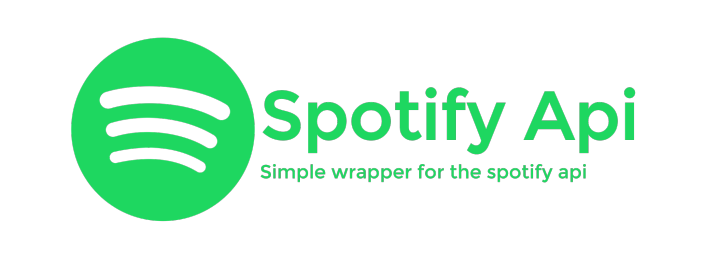

For every track on their platform, Spotify provides data for thirteen Audio Features.The [Spotify Web API developer]('https://developer.spotify.com/') guide defines them as follows:

**Danceability**: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

**Valence**: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

**Energy**: Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.

**Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration.

**Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.

**Speechiness**: This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.

**Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”.

**Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

**Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.

**Key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
Mode: Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

**Duration**: The duration of the track in milliseconds.

**Time Signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

# Section 1: Motivation

**MOTIVATION**

Music changes people's mood and connects people and Spotify is the main source that consumers use when it comes to listening to music. Our team will use Spotify Web API to work with a spotify dataset from [Kaggle](https://www.kaggle.com/datasets/ektanegi/spotifydata-19212020) that contains more than 586,672 songs from 1921 until 2021. The goal is to build a song recommendor for people based on features that are related with their playlist preferences. In addition, we want to explore music trends throughout the years in order to build a song popularity predictor that features the trening song attributes.

  Working with the Spotify dataset to make these predictions will allow us to get a thorough understanding on motivation drivers about people in conjunction with trends and perception about music.

We chose this particular Spotify dataset for a couple reasons: \
1. It consists many songs. Therefore, we have more data to see trends and build models with
2. It consists many features that we were interested in working with. For instance, tbis dataset contains information regarding the genre, artist's popularity, and artist's number of followers on Spotify. It was somewhat difficult to find a dataset with all of these features.
3. This dataset has a usability of ***2.94/10***, making it extremely difficult to work with.  Many datasets on Kaggle require very little cleaning if any at all.  We wanted to make this project more challenging and realistic (since data scientists spend 80-90% of their time cleaning) by using a dataset like this. Just a couple difficulties with this dataset include as follows:
  - Columns with null values
  - Join incompatibility (many songs had multiple artists making it more difficult to join the track and artist datasets
  - Too many genres to accurately place into a broad genre
  - Some of the same songs were duplicates with various ids.
  - Many song genres were unknown
  - A lot of variance in columns that were important for predicting song_popularity (artist_popularity, year, etc.)

In the end, we were able to work through most of these problems in the dataset using principles we learned in class

# Section 2: Imports and Data Collection

## Imports and Connecting to Drive

In [ ]:
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import wordcloud
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display

In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pd.set_option('display.max_columns', 500)

In [ ]:
#connecting to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Collecting Data From Kaggle


Now we will collect the datasets from Kaggle.

In [ ]:
#install kaggle library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#make new directory for kaggle data
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#copy contents of Kaggle json file to new directory
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
#download dataset from kaggle to notebook
!kaggle datasets download -d lehaknarnauli/spotify-datasets

spotify-datasets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzip spotify-datasets.zip
!unzip spotify-datasets.zip

Archive:  spotify-datasets.zip
replace artists.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: artists.csv             
replace tracks.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tracks.csv              


# Section 3: Exploring Raw Data and Cleaning

In this section, we will explore our raw data prior to making enhancements and then clean the dataset so it is satisfactory for the project's next steps.  Since the usability of this dataset was 2.94, this dataset required many adjustments.  This section alone took the longest to implement and required many frequent adjustments. 

## Exploring Raw Data

In [ ]:
#Read in csv files
df_artists = pd.read_csv('artists.csv')
df_tracks = pd.read_csv('tracks.csv')

In [ ]:
#Find the size of each dataset (# rows, # columns)
print(df_artists.shape)
print(df_tracks.shape)

(1104349, 5)
(586672, 20)


We see that the datasets are very large. Note, df_artists is about twice as large as df_tracks.

In [ ]:
#Print first 5 entres of df_artists
df_artists.head(5)

id  followers genres  \
0  0DheY5irMjBUeLybbCUEZ2        0.0     []   
1  0DlhY15l3wsrnlfGio2bjU        5.0     []   
2  0DmRESX2JknGPQyO15yxg7        0.0     []   
3  0DmhnbHjm1qw6NCYPeZNgJ        0.0     []   
4  0Dn11fWM7vHQ3rinvWEl4E        2.0     []   

                                             name  popularity  
0  Armid & Amir Zare Pashai feat. Sara Rouzbehani           0  
1                                     ปูนา ภาวิณี           0  
2                                           Sadaa           0  
3                                       Tra'gruda           0  
4                          Ioannis Panoutsopoulos           0

In [ ]:
#Print first 5 entres of df_tracks
df_tracks.head(5)

id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechiness  \
0   1922-02-22         0.645  0.4450    0   -13.338     1       0.4510   
1   1922-06-01         0.695  0.2630    0   -22.136     1       0.9570   
2   1922-03-21         0.434  0.1770    1   -21.180     1       0.0512   
3   1922-03-21         0.321  0.0946    7   -27.961     1       0.0504   
4         1922         0.402  0.1580    3   -16.900     0       0.0390   

   acousticness  instrumentalness  liveness  valence    tempo  time_signature  
0         0.674            0.7440     0.151    0.127  104.851               3  
1         0.797            0.0000     0.148    0.655  102.009               1  
2         0.994            0.0218     0.212    0.457  130.418               5  
3         0.995            0.9180     0.104    0.397  169.980               3  
4         0.989            0.1300     0.311    0.196  103.220               4

In [ ]:
#Explore info of df_artists
df_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104349 entries, 0 to 1104348
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1104349 non-null  object 
 1   followers   1104336 non-null  float64
 2   genres      1104349 non-null  object 
 3   name        1104349 non-null  object 
 4   popularity  1104349 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 42.1+ MB


In [ ]:
#Explore info of df_tracks
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [ ]:
# Check nulls of df_artists
df_artists.isna().sum()

id             0
followers     13
genres         0
name           0
popularity     0
dtype: int64

In [ ]:
#Check nulls of df_tracks
df_tracks.isna().sum()

id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

## Cleaning

Now, let's start cleaning the data.

### Transform Columns: genres, artists, and id_artists

First, we wanted to remove the brackets in the artists column in df_tracks, id_artists in df_tracks, and genres in df_artists.  We thought this would make it easier to find null values.

In [ ]:
#Removing brackets from the cells in the artists column
df_tracks["artists"]=df_tracks["artists"].str.replace("[", "")
df_tracks["artists"]=df_tracks["artists"].str.replace("]", "")
df_tracks["artists"]=df_tracks["artists"].str.replace("'", "")

#Replacing blank cells with null so we know to transform them
#Used: https://sparkbyexamples.com/pandas/pandas-replace-blank-values-with-nan/
df_tracks["artists"] = df_tracks["artists"].replace(r'^\s*$', np.nan, regex=True)

In [ ]:
#Removing brackets from the cell in the id_artists column
df_tracks["id_artists"]=df_tracks["id_artists"].str.replace("[", "")
df_tracks["id_artists"]=df_tracks["id_artists"].str.replace("]", "")
df_tracks["id_artists"]=df_tracks["id_artists"].str.replace("'", "")

#Replacing blank cells with null so we know to transform them
#Used: https://sparkbyexamples.com/pandas/pandas-replace-blank-values-with-nan/
df_tracks["id_artists"] = df_tracks["id_artists"].replace(r'^\s*$', np.nan, regex=True)

In [ ]:
#Removing brackets from the cell in the genres column
df_artists["genres"]=df_artists["genres"].str.replace("[", "")
df_artists["genres"]=df_artists["genres"].str.replace("]", "")
df_artists["genres"]=df_artists["genres"].str.replace("'", "")

#Replacing blank cells with null so we know to transform them
#Used: https://sparkbyexamples.com/pandas/pandas-replace-blank-values-with-nan/
df_artists["genres"] = df_artists["genres"].replace(r'^\s*$', 'unknown', regex=True)

### Handling Null Values

As we saw in the previous section there are 13 null values in df_artists's followers column.  Since this is such a low number and artists are not very popular overall (as seen below), we decided to replace the null followers values with the average number of followers of artists of the same popularity in the dataset.

In [ ]:
#define df_fill - dataframe that consists null values from df_artists
df_fill = df_artists[df_artists.isnull().any(axis=1)]

Let's take a look at these rows.

In [ ]:
df_fill

id  followers              genres  \
444199  7F71W80jaXFARK7hBjsDI2        NaN           czech pop   
444200  3MLHJz04KmEVzCTPclzkEm        NaN           czech pop   
444797  0cqZsULDZdJTGA4Zqh8Ckv        NaN             unknown   
444798  0BuknWzKujyc9HfZ1V50Uk        NaN             unknown   
446635  6ltU5gIDLmWNYaVNHnll5G        NaN  mexican electronic   
446636  7C9nWRMbRqpPUuKh2OEw9n        NaN             unknown   
446637  41c30F8zy5UCTSevbn0WfD        NaN  mexican electronic   
468525  1DK979aOesiZ4Vkus8txqu        NaN             unknown   
468526  6jkpqSWWsXSuqtsoeAiMDU        NaN        uk americana   
468527  7aMdHPv79qOuqqBD6TnaCp        NaN             unknown   
468528  2lr0R5vHGfI0C489h0r6qV        NaN            dc indie   
468529  0xkSOIeyeTILNIOZKyFgaP        NaN             unknown   
468530  4EqqnE0XMAcreVF84QGYJ0        NaN             unknown   

                                                     name  popularity  
444199                                            Marcell          36  
444200                                               Niko          21  
444797                                           Savzilla           0  
444798                                          Duck Doja           0  
446635                                               Zofa           0  
446636                                                MHV           3  
446637                                     Broadband Star           0  
468525              AmorArtis Orchestra & Johannes Somary           2  
468526                                   Police Dog Hogan          14  
468527                Miles Davis & Charlie "Bird" Parker           0  
468528                                    Black Dog Prowl          16  
468529  Band of the Fifteenth Field Artillery Regiment...           3  
468530                             Robert Steven Williams           0

In [ ]:
#function that finds the average followers of all artists with the same popularity
def avg_followers_by_popularity(df, p):
  avg_followers = df[df['popularity'] == p]['followers'].mean()
  return avg_followers

#apply each row to the function above
df_fill['followers'] = df_fill['popularity'].apply(lambda x: round(avg_followers_by_popularity(df_artists, x)))

#check to see that all values are filled
df_fill.head(13)

id  followers              genres  \
444199  7F71W80jaXFARK7hBjsDI2      10034           czech pop   
444200  3MLHJz04KmEVzCTPclzkEm       2056           czech pop   
444797  0cqZsULDZdJTGA4Zqh8Ckv         53             unknown   
444798  0BuknWzKujyc9HfZ1V50Uk         53             unknown   
446635  6ltU5gIDLmWNYaVNHnll5G         53  mexican electronic   
446636  7C9nWRMbRqpPUuKh2OEw9n        237             unknown   
446637  41c30F8zy5UCTSevbn0WfD         53  mexican electronic   
468525  1DK979aOesiZ4Vkus8txqu        176             unknown   
468526  6jkpqSWWsXSuqtsoeAiMDU       1034        uk americana   
468527  7aMdHPv79qOuqqBD6TnaCp         53             unknown   
468528  2lr0R5vHGfI0C489h0r6qV       1262            dc indie   
468529  0xkSOIeyeTILNIOZKyFgaP        237             unknown   
468530  4EqqnE0XMAcreVF84QGYJ0         53             unknown   

                                                     name  popularity  
444199                                            Marcell          36  
444200                                               Niko          21  
444797                                           Savzilla           0  
444798                                          Duck Doja           0  
446635                                               Zofa           0  
446636                                                MHV           3  
446637                                     Broadband Star           0  
468525              AmorArtis Orchestra & Johannes Somary           2  
468526                                   Police Dog Hogan          14  
468527                Miles Davis & Charlie "Bird" Parker           0  
468528                                    Black Dog Prowl          16  
468529  Band of the Fifteenth Field Artillery Regiment...           3  
468530                             Robert Steven Williams           0

Now let's drop the rows that consist null values in df_artists and replace with the newly filled rows.

In [ ]:
#drop rows with null values
df_artists = df_artists.dropna()

#concatenate df_artists and df_fill
df_artists = pd.concat([df_artists, df_fill]) 

Next, let's address the null vallues in df_tracks.

In [ ]:
#prints all rows with null values in the dataset
df_tracks[df_tracks.isnull().any(axis=1)]

id name  popularity  duration_ms  explicit  \
226336  4iH7negBYMfj2z0wDNmgdx  NaN          28       264973         0   
510975  04d5kbLvSAIBt3pGcljdhC  NaN           0       184293         0   
510976  05tRkgyxVdwMePGqOXMDYU  NaN           0       191587         0   
510978  0YAMRgAQH6tkTh4sWNXr8L  NaN           0       191573         0   
510979  1K6MQQxmFpPb66ZnaiIpHX  NaN           0       167602         0   
...                        ...  ...         ...          ...       ...   
517206  6OH9mz9aFbGlbf74cBwYWD  NaN           2       209760         0   
517215  15RqFDA86slfzujSQMEX4i  NaN           2       257280         0   
520127  0hKA9A2JPtFdg0fiMhyjQD  NaN           6       194081         0   
525238  1kR4gIb7nGxHPI3D2ifs59  NaN          26       289440         0   
525265  4xyBq8t4nkUKH8s28j6ZoD  NaN          24       254000         0   

       artists              id_artists release_date  danceability  energy  \
226336     NaN  0LyfQWJT6nXafLPZqxe9Of   1994-01-01         0.512   0.578   
510975     NaN  0LyfQWJT6nXafLPZqxe9Of   1922-04-01         0.426   0.285   
510976     NaN  0LyfQWJT6nXafLPZqxe9Of   1922-04-01         0.344   0.186   
510978     NaN  0LyfQWJT6nXafLPZqxe9Of   1922-04-01         0.316   0.257   
510979     NaN  0LyfQWJT6nXafLPZqxe9Of   1922-04-01         0.558   0.283   
...        ...                     ...          ...           ...     ...   
517206     NaN  0LyfQWJT6nXafLPZqxe9Of   1962-02-01         0.506   0.598   
517215     NaN  0LyfQWJT6nXafLPZqxe9Of   1962-02-01         0.612   0.615   
520127     NaN  0LyfQWJT6nXafLPZqxe9Of   1974-12-31         0.471   0.369   
525238     NaN  0LyfQWJT6nXafLPZqxe9Of   1998-01-05         0.501   0.583   
525265     NaN  0LyfQWJT6nXafLPZqxe9Of   1998-01-05         0.390   0.452   

        key  loudness  mode  speechiness  acousticness  instrumentalness  \
226336    0   -12.280     0       0.0299        0.0433          0.000064   
510975   11   -11.970     1       0.0466        0.9950          0.264000   
510976    0   -13.495     1       0.0745        0.9950          0.000000   
510978    3   -13.611     0       0.0549        0.9950          0.769000   
510979    1   -12.847     1       0.0646        0.9960          0.000000   
...     ...       ...   ...          ...           ...               ...   
517206    7    -4.672     0       0.0635        0.7710          0.000001   
517215    5    -5.609     1       0.0551        0.8540          0.000023   
520127    4   -12.927     0       0.1460        0.9680          0.001100   
525238    7    -9.460     0       0.0605        0.6900          0.003960   
525265    7    -9.900     1       0.0361        0.7370          0.000000   

        liveness  valence    tempo  time_signature  
226336    0.5160    0.692  156.465               1  
510975    0.2930    0.583  135.661               4  
510976    0.1150    0.290   79.591               1  
510978    0.5190    0.529   68.682               3  
510979    0.4530    0.608   70.379               4  
...          ...      ...      ...             ...  
517206    0.6910    0.800   91.172               4  
517215    0.0541    0.809   90.536               4  
520127    0.1410    0.766   94.063               4  
525238    0.0747    0.734  138.391               4  
525265    0.1110    0.662   94.630               4  

[71 rows x 20 columns]

It looks like the ID of the artist are all the same. Let's groupby id_artists and check.

In [ ]:
df_tracks[df_tracks.isnull().any(axis=1)].groupby(by='id_artists')['id'].count()

id_artists
0LyfQWJT6nXafLPZqxe9Of    71
Name: id, dtype: int64

We looked up the artist with this id at https://open.spotify.com/artist/0LyfQWJT6nXafLPZqxe9Of and it appears the artist is 'Various Artists'.  We decided to drop these values from df_tracks, because we want to elimate this ambiguity. 

In [ ]:
#drop rows with null values
df_tracks = df_tracks.dropna()

### Dropping Unused Rows in df_artists

Since artist_df is twice the size of tracks_df, we expect many artists will not be matched to a track. Therefore, let's only keep artists that are in df_track to make our job a little easier since we'll only be needing the song data.

In [ ]:
#making a list of all the used ids
ids_list = []

for row in df_tracks['id_artists']:
  row_list = row.split(', ')
  ids_list += row_list

In [ ]:
#see how many ids in df_artists are in df_tracks
#True indicates the id is in df_tracks
df_artists['id'].isin(ids_list).value_counts()

False    1022966
True       81383
Name: id, dtype: int64

We see that this would make a remarkable difference as we only use 10% of the rows in df_artists. Let's only keep the artists that are in df_tracks.

In [ ]:
#only takes rows where the id is in ids_list (list of ids in df_tracks)
df_artists = df_artists[df_artists['id'].isin(ids_list)]

### Adding Genre Feature to df_artists

Next, we'll find the broad features to categorize each artist's primary genre. We decided to classify the broad genre based on keywords in each row's genre list, which consists 2-4 very specific genres. We chose to group the 4250 unique genres into the following broad categories: \

- Rap - hip hop and trap songs
- Pop - any song with pop in the name
- Oldies - songs from the 1940s-1950s that are classified by adult standard or easy listening
- R&B - r&b songs 
  - This is commonly grouped with rap but we wanted to make it it's own category since the speed and danceability of rap and r&b songs are very different
- Religion - religious songs, mostly gospel and Christian tunes
- Latin - songs based in Central and Southern America
- Jazz/Blues - jazz, blues, groove, etc.
- Folk - folk.. this is more popular then you think, which is why we made it it's own category.
- Children - lullaby, baby, and children's songs. This is also more popular than you would think.
- Dance - EDM, electronic tunes
- Soundtrack - songs that from movie and tv show soundtracks.. this is also more popular than you would think and it was difficult to place these in order categories
- Country - just country music
- Rock - alternative, classic rock, and other popular genres we found to be a part of the rock umbrella
- Classical - songs with musical instruments
- Unknown - songs we did not have the genre data for
- Other - songs that did not match the categories above
  - We chose to seperate Unknown and Other because Other just doesn't match the popular categories we tried to find.  However unknown was what we couldn't find the data for.

This was one of the most challeging aspects of the project for several reasons: \

1.  Some artists have songs from multiple categories and some songs have multiple categories. This is why the order of the if statements was important. It was also easier to assume all of their songs fall under the category they're known for.
2. Initially we didn't have many broad categories (just Rap, Pop, Country, Classical, and Rock), but as we explored the data and saw how many songs were uncategorized, we recognized the importance of having more broad genres and using more key words in order to place songs in the correct genres. To do this we would find songs that were find mostly commonly uncategorized genres, do a Google search to, and place a key word in the appropriate category.  Therefore, we spent a lot of time tweaking this.


In the end, many broad genres still could not be determined, but we did the best we could be classify as many artists's broad genres as possible.

We also tried using a word similarity library to simplify this but it wasn't nearly as fast and effective as what we did here.

In [ ]:
def find_broad_category(category):
  if 'rap' in category or 'hip hop' in category or 'trap' in category or 'freestyle' in category or 'drill' in category or 'bboy' in category:
    return 'rap'
  elif 'pop' in category:
    return 'pop'
  elif 'adult standards' in category or 'vintage' in category or 'easy listening' in category or 'old' in category:
    return 'oldies'
  elif 'r&b' in category:
    return 'r&b'
  elif 'gospel' in category or 'worship' in category or 'ccm' in category or 'judaica' in category or \
  'christian' in category or 'cathedral' in category:
    return 'religion'
  elif 'latin' in category or 'tango' in category or 'reggae' in category or 'corrido' in category or 'trova' in category or\
  'salsa' in category or 'cumbia uruguaya' in category or 'ranchera' in category or 'regional mexican' in category or 'grupera' in category or\
  'pagode' in category or 'samba' in category or 'musica' in category or 'cumbia' in category or 'mpb' in category or \
  'spanish' in category or 'bossa nova' in category or 'brazilian' in category or 'mexican' in category or 'mariachi' in category or \
  'espanol' in category or 'sertanejo' in category or 'vallenato' in category or 'merengue' in category or 'cuarteto' in category:
    return 'latin'
  elif 'jazz' in category or 'blues' in category or 'groove' in category or\
  'harlem renaissance' in category or 'jug band' in category or 'soul' in category or 'big band' in category or \
  'stride' in category or 'swing' in category or 'soul' in category:
    return 'jazz/blues'
  elif 'folk' in category or 'rebetiko' in category or 'arabesk' in category or 'manele' in category or 'fiddle' in category:
    return 'folk'
  elif 'children' in category or 'barnsagor' in category or 'baby' in category or 'infant' in category or 'lullaby' in category or\
  'barnmusik' in category or 'musiikkia lapsille' in category or 'bornesange' in category or 'barnalog' in category or\
  'barnemusikk' in category or 'detske pesnicky' in category or 'muziek voor kinderen' in category or 'kids' in category:
    return 'children'
  elif 'electric' in category or 'dance' in category or 'edm' in category or 'electro' in category or 'dub' in category or\
  'tech' in category or 'house' in category or 'trance' in category or 'disco' in category or 'funk' in category or 'wave' in category or 'party' in category:
    return 'dance'
  elif 'bollywood' in category or 'filmi' in category or 'kollywood' in category or 'movie' in category or 'disney' in category or\
  'soundtrack' in category or 'broadway' in category or 'tollywood' in category or 'hollywood' in category:
    return 'soundtrack'
  elif 'country' in category or 'cowboy' in category or 'bluegrass' in category or 'nashville' in category:
    return 'country'
  elif 'rock' in category or 'metal' in category or 'punk' in category or 'indie' in category or \
  'hardcore' in category or 'alternative' in category or 'mellow gold' in category or 'kindermusik' in category or\
  'kayokyoku' in category or 'dansband' in category:
    return 'rock'
  elif 'classical' in category or 'piano' in category or 'romantic' in category or 'violin' in category or\
  'harp' in category or 'hoerspiel' in category or 'ballroom' in category or 'orchestra' in category or\
  'saxophone' in category or 'instrumental' in category or 'flute' in category or 'brass' in category or \
  'opera' in category or 'fado' in category:
    return 'classical'
  elif 'unknown' in category:
    return 'unknown'
  else:
    return 'other'

In [ ]:
df_artists['broad_genres'] = df_artists['genres'].apply(lambda x: find_broad_category(x))

In [ ]:
df_artists['broad_genres'].value_counts()

unknown       25219
pop           16854
rap            7659
other          7234
rock           5008
latin          4510
dance          3396
jazz/blues     2830
classical      2240
folk           1838
soundtrack     1269
oldies         1025
religion        915
country         588
children        535
r&b             263
Name: broad_genres, dtype: int64

Let's manually fill some of the most popular artists's broad genres.

In [ ]:
df_artists[df_artists['broad_genres'] == 'unknown'].sort_values(by='popularity', ascending=False)[0:15]

id  followers   genres                  name  \
895644  6PvvGcCY2XtUcSRld1Wilr   166844.0  unknown            Silk Sonic   
54721   48HORs6F9P7IgdyKrk4MZC   590066.0  unknown  Tarcísio do Acordeon   
59396   4L2dV3zY7RmkeiNO035Fi0     2614.0  unknown      Mufasa & Hypeman   
126387  3eVa5w3URK5duf6eyVDbu9   639381.0  unknown                  ROSÉ   
101141  1PKErrAhYFdfrDymGHRQRo    93596.0  unknown          Nathan Evans   
146878  1gALaWbNDnwS2ECV09sn2A    31103.0  unknown         Nightcrawlers   
59395   3Edve4VIATi0OZngclQlkN      480.0  unknown              Dopamine   
167296  4YYxffPVDFe9XoqqbRW6Bq   165447.0  unknown               L-Gante   
59398   5PoZtBo8xZKqPWlZrIDq82     1414.0  unknown            Billen Ted   
213154  4Euia7UzdRshy1DJOSMTcs     9496.0  unknown               220 KID   
145121  2NfSBtmWe7oPw1EmetJVso   224299.0  unknown                  Boza   
288010  5H4yInM5zmHqpKIoMNAx4r   158890.0  unknown           Central Cee   
147766  3z97WMRi731dCvKklIf2X6  1230807.0  unknown                NEFFEX   
114525  1r1uxoy19fzMxunt3ONAkG   642693.0  unknown       Phoebe Bridgers   
33342   3HphLd0XiELTvIPYf55dYC    17849.0  unknown  Strange Fruits Music   

        popularity broad_genres  
895644          83      unknown  
54721           81      unknown  
59396           80      unknown  
126387          80      unknown  
101141          80      unknown  
146878          80      unknown  
59395           80      unknown  
167296          79      unknown  
59398           78      unknown  
213154          78      unknown  
145121          78      unknown  
288010          78      unknown  
147766          77      unknown  
114525          77      unknown  
33342           77      unknown

In [ ]:
#fill Silk Sonic's cell 
df_artists.loc[895644, 'broad_genres'] = 'rap'
#fill Mufasa & Hypeman's cell 
df_artists.loc[59396, 'broad_genres'] = 'dance'
#fill Nightcrawlers's cell
df_artists.loc[146878, 'broad_genres'] = 'dance'
#fill Dopamine's cell
df_artists.loc[59395, 'broad_genres'] = 'dance'
#fill L-Gante's cell
df_artists.loc[167296, 'broad_genres'] = 'latin'
#fill Billen Ted's cell
df_artists.loc[59398, 'broad_genres'] = 'latin'
#fill Central cee's cell
df_artists.loc[288010, 'broad_genres'] = 'rap'

In [ ]:
df_artists[df_artists['broad_genres'] == 'unknown'].sort_values(by='followers', ascending=False)[0:15]

id  followers   genres                  name  \
145524  2mxe0TnaNL039ysAj51xPQ  2257404.0  unknown              R. Kelly   
147766  3z97WMRi731dCvKklIf2X6  1230807.0  unknown                NEFFEX   
62128   2CQZr2RPZmrcvDnaod1ldC   964160.0  unknown                  D.O.   
128642  2XzXLjXRSeFtsic4ieyLJy   791547.0  unknown           Wilbur Soot   
114525  1r1uxoy19fzMxunt3ONAkG   642693.0  unknown       Phoebe Bridgers   
126387  3eVa5w3URK5duf6eyVDbu9   639381.0  unknown                  ROSÉ   
144671  34v5MVKeQnIo0CWYMbbrPf   638402.0  unknown           John Newman   
54721   48HORs6F9P7IgdyKrk4MZC   590066.0  unknown  Tarcísio do Acordeon   
114564  4FUMTycjZlEY6ZxMgqNjC8   578907.0  unknown                Tierry   
141211  6RGxLsQUoGk5PLyMVwb3yE   444464.0  unknown      Sananda Maitreya   
91290   0UdoKjWIe3tHyiqc4qT3Oz   430472.0  unknown                  OMFG   
53990   6TgVQhHx0BWvzdEQxRnr23   409359.0  unknown                 POLLO   
976526  6Rx1JKzBrSzoKQtmbVmBnM   387723.0  unknown       Hayley Williams   
67245   5uUb3J6HqLhBWwzuh84LUZ   356954.0  unknown             Seventeen   
126772  6oMRQ5H3A2XA5I3RG3leni   334876.0  unknown         DJ Alan Gomez   

        popularity broad_genres  
145524          72      unknown  
147766          77      unknown  
62128           55      unknown  
128642          72      unknown  
114525          77      unknown  
126387          80      unknown  
144671          71      unknown  
54721           81      unknown  
114564          75      unknown  
141211          56      unknown  
91290           57      unknown  
53990           49      unknown  
976526          71      unknown  
67245           52      unknown  
126772          72      unknown

In [ ]:
#fill R. Kelly's cell 
df_artists.loc[145524, 'broad_genres'] = 'rap'
#fill NEFFEX's cell 
df_artists.loc[147766, 'broad_genres'] = 'dance'
#fill Wilbur Soot's cell 
df_artists.loc[128642, 'broad_genres'] = 'pop'
#fill Phoebe Bridgers's cell
df_artists.loc[114525, 'broad_genres'] = 'rock'
#fill ROSÉ's cell
df_artists.loc[126387, 'broad_genres'] = 'pop'
#fill John Newman's cell
df_artists.loc[144671, 'broad_genres'] = 'pop'
#fill DJ Alan Gomez's cell
df_artists.loc[126772, 'broad_genres'] = 'dance'

### Rename Columns and Merge df_tracks and df_artists

Now in this section, we'll rename some of the columns to make them more precise and finally join df_tracks and df_artists.

In [ ]:
df_artists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81383 entries, 137 to 444199
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            81383 non-null  object 
 1   followers     81383 non-null  float64
 2   genres        81383 non-null  object 
 3   name          81383 non-null  object 
 4   popularity    81383 non-null  int64  
 5   broad_genres  81383 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.4+ MB


In [ ]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586601 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586601 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586601 non-null  int64  
 3   duration_ms       586601 non-null  int64  
 4   explicit          586601 non-null  int64  
 5   artists           586601 non-null  object 
 6   id_artists        586601 non-null  object 
 7   release_date      586601 non-null  object 
 8   danceability      586601 non-null  float64
 9   energy            586601 non-null  float64
 10  key               586601 non-null  int64  
 11  loudness          586601 non-null  float64
 12  mode              586601 non-null  int64  
 13  speechiness       586601 non-null  float64
 14  acousticness      586601 non-null  float64
 15  instrumentalness  586601 non-null  float64
 16  liveness          58

In [ ]:
#Rename columns to make names more precise
df_tracks = df_tracks.rename(columns={'name':'song_name', 'popularity':'song_popularity', 'id':'song_id'})
df_artists = df_artists.rename(columns={'id':'id_artists', 'popularity':'artist_popularity', 'name':'artists_name'})

In [ ]:
#Left merge of df_tracks and df_artists
df_merge = df_tracks.merge(df_artists, how='left', on='id_artists')

In [ ]:
#dropping artists_name column because its a duplicate of artists
df_merge = df_merge.drop(columns=['artists_name'])

Reordering the dataframe so that it's that the most features are placed on the left.

In [ ]:
df_merge = df_merge[['song_name', 'artists', 'release_date', 'broad_genres', 'genres', 'song_popularity', 'artist_popularity', 'followers', \
                     'song_id', 'id_artists', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', \
                     'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', \
                     'time_signature']]

Now let's check null values of the new dataset.

In [ ]:
#Finds total number of null values in each column
df_merge.isna().sum()

song_name                 0
artists                   0
release_date              0
broad_genres         117018
genres               117018
song_popularity           0
artist_popularity    117018
followers            117018
song_id                   0
id_artists                0
duration_ms               0
explicit                  0
danceability              0
energy                    0
key                       0
loudness                  0
mode                      0
speechiness               0
acousticness              0
instrumentalness          0
liveness                  0
valence                   0
tempo                     0
time_signature            0
dtype: int64

From here, we see that many of the null values have multiple artists. This is because we row in df_artists had one id corresponding to one artists and some rows in df_tracks have multiple ids for multiple artists. In the next section, we'll look at how to handle this.

In [ ]:
#Rows with null values in the dataset grouped by artists 
df_merge[df_merge.isnull().any(axis=1)].groupby(by='artists')['song_id'].count()[0:15]

artists
"5nizza", dunkelbunt                                      1
"AKA ChaP in 00S"                                         1
"Aidan ORourke", Kit Downes                               1
"Alan Daveys Eclectic Devils"                             1
"Alex DElia", Nihil Young                                 1
"Alexander ONeal", Cherrelle                              1
"Alfa"                                                    1
"Alibi Montana feat. Diams", "Diams"                      1
"Alix Combelles Hot Four", Alix Combelle                  4
"Amy Hanaialii", Willie K                                 1
"AnOm", Vayn                                              1
"Anita ODay", Billy May Orchestra                         1
"Anita ODay", Cal Tjader                                  1
"Anita ODay", Gene Krupa & His Orchestra                  2
"Anita ODay", Gene Krupa & His Orchestra, Roy Eldridge    2
Name: song_id, dtype: int64

### Handling Nulls From Rows with Multiple Artists

ITo resolve this issue, we will iteratively extract each individual id where there are multiple and attempt to merge it with df_artists. We will start with the first artist's id, assuming the first artist is the most popular, leading to a more accurate portrayal of how popular the song is.  If we can't find a match for the first artist, we'll look at the second artist, third artist and so on until we can no longer find matches.  We'll try this for up to 15 artists.

In [ ]:
print('Init null values')
print(df_merge['followers'].isna().sum())

#Get rows with null values
df_nulls = df_merge[df_merge.isnull().any(axis=1)]
#Extract the first artist's id and place it in a column
df_nulls['artist_id_0'] = df_nulls['id_artists'].apply(lambda x: x.split(', ')[0])
#Find the number of artists for every song
df_nulls['num_artists'] = df_nulls['id_artists'].apply(lambda x: len(x.split(', ')))
#Merge with df_artists
df_nulls = df_nulls.merge(df_artists, how='left', left_on='artist_id_0', right_on='id_artists')
#Drop and rename necessary columns
df_nulls = df_nulls.drop(columns=['genres_x', 'artist_popularity_x', 'followers_x', 'artist_id_0', \
                                  'id_artists_y','artists_name', 'broad_genres_x'])
df_nulls = df_nulls.rename(columns={'id_artists_x':'id_artists', 'followers_y': 'followers', 'genres_y':'genres',\
                                    'artist_popularity_y': 'artist_popularity', 'broad_genres_y': 'broad_genres'})
print('Remaining nulls after Round 1:')
print(df_nulls['followers'].isna().sum())
#Drop nulls and call df_concat
df_concat = df_nulls.dropna()

for i in range(1,15):
  #Get rows with null values
  df_nulls = df_nulls[df_nulls.isnull().any(axis=1)]
  #Extract values wear there is more than i artists
  df_nulls = df_nulls[df_nulls['num_artists'] > i]
  #Extract the next artist's id and place it in a column
  df_nulls['artist_id_{}'.format(i)] = df_nulls['id_artists'].apply(lambda x: x.split(', ')[i])
  #Merge with df_artists
  df_nulls = df_nulls.merge(df_artists, how='left', left_on='artist_id_{}'.format(i), right_on='id_artists')
  #Drop and rename necessary columns
  df_nulls = df_nulls.drop(columns=['genres_x', 'artist_popularity_x', 'followers_x', 'artist_id_{}'.format(i), \
                                  'id_artists_y', 'artists_name', 'broad_genres_x'])
  df_nulls = df_nulls.rename(columns={'id_artists_x':'id_artists', 'followers_y': 'followers', 'genres_y':'genres',\
                                    'artist_popularity_y': 'artist_popularity', 'broad_genres_y': 'broad_genres'})
  print('Remaining nulls after Round {}:'.format(i+1))
  print(df_nulls['followers'].isna().sum())
  df_updated = df_nulls.dropna()
  df_concat = pd.concat([df_concat, df_updated])

Init null values
117018
Remaining nulls after Round 1:
12344
Remaining nulls after Round 2:
1001
Remaining nulls after Round 3:
219
Remaining nulls after Round 4:
51
Remaining nulls after Round 5:
29
Remaining nulls after Round 6:
23
Remaining nulls after Round 7:
16
Remaining nulls after Round 8:
1
Remaining nulls after Round 9:
1
Remaining nulls after Round 10:
1
Remaining nulls after Round 11:
1
Remaining nulls after Round 12:
1
Remaining nulls after Round 13:
1
Remaining nulls after Round 14:
0
Remaining nulls after Round 15:
0


It looks like we were able to match all 117018 columns in the list after 15 iterations. Now let's remove all the null values from df_merge and concatenate these newly filled rows.

In [ ]:
#Drop all nulls from df_merge
df_merge = df_merge.dropna()

#rearrange column order so we can concat
df_nulls = df_nulls[list(df_merge.columns)]

df = pd.concat([df_merge, df_nulls])

Now, let's check to ensure all nulls were dropped.

In [ ]:
df.isna().sum()

song_name            0
artists              0
release_date         0
broad_genres         0
genres               0
song_popularity      0
artist_popularity    0
followers            0
song_id              0
id_artists           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

### Dropping Song Duplicates and Other Values

Let's drop the rows where the artist is Workout Music and Various Artists because it is too obscure for our model.

In [ ]:
df = df[(df['artists'] != 'Workout Music') & (df['artists'] != 'Various Artists')]

We noticed that some of the same songs by the same artists had duplicates. For instance:

In [ ]:
df[df['song_name'] == "Born This Way"]

song_name    artists release_date broad_genres  \
84133   Born This Way  Lady Gaga   2011-05-23          pop   
303535  Born This Way  Lady Gaga   2011-01-01          pop   
303672  Born This Way  Lady Gaga   2011-01-01          pop   
353017  Born This Way  Lady Gaga   2021-04-13          pop   
353018  Born This Way  Lady Gaga   2021-04-13          pop   
558798  Born This Way  Lady Gaga   2011-01-01          pop   

                               genres  song_popularity  artist_popularity  \
84133   dance pop, pop, post-teen pop               74               89.0   
303535  dance pop, pop, post-teen pop               69               89.0   
303672  dance pop, pop, post-teen pop               53               89.0   
353017  dance pop, pop, post-teen pop                0               89.0   
353018  dance pop, pop, post-teen pop                0               89.0   
558798  dance pop, pop, post-teen pop               47               89.0   

         followers                 song_id              id_artists  \
84133   17047864.0  30XU4suKzCeoCK9YFzdufg  1HY2Jd0NmPuamShAr6KMms   
303535  17047864.0  6r2BECwMgEoRb5yLfp0Hca  1HY2Jd0NmPuamShAr6KMms   
303672  17047864.0  6aDi4gOE2Cfc6ecynvP81R  1HY2Jd0NmPuamShAr6KMms   
353017  17047864.0  0n5iwOwzox8e9mjMhG7Rea  1HY2Jd0NmPuamShAr6KMms   
353018  17047864.0  1RTbgb0BantdgL67BFFCrT  1HY2Jd0NmPuamShAr6KMms   
558798  17047864.0  6lEQQ4PJNJrF2Sp9AjaC67  1HY2Jd0NmPuamShAr6KMms   

        duration_ms  explicit  danceability  energy  key  loudness  mode  \
84133        260253         0         0.587   0.828   11    -5.108     1   
303535       260253         0         0.587   0.828   11    -5.108     1   
303672       260253         0         0.586   0.827   11    -5.102     1   
353017       260413         0         0.586   0.835   11    -5.117     1   
353018       260413         0         0.586   0.835   11    -5.117     1   
558798       260253         0         0.587   0.828   11    -5.108     1   

        speechiness  acousticness  instrumentalness  liveness  valence  \
84133         0.161       0.00327               0.0     0.331    0.494   
303535        0.161       0.00327               0.0     0.331    0.494   
303672        0.150       0.00370               0.0     0.328    0.508   
353017        0.146       0.00387               0.0     0.304    0.492   
353018        0.146       0.00387               0.0     0.304    0.492   
558798        0.161       0.00327               0.0     0.331    0.494   

          tempo  time_signature  
84133   123.907               4  
303535  123.907               4  
303672  123.905               4  
353017  123.936               4  
353018  123.936               4  
558798  123.907               4

To resolve this, let's sort the entire dataset in descending order of song popularity and remove all song duplicates (keeping the first instance that is the most popular).

In [ ]:
print('Before duplicates dropped', len(df))

Before duplicates dropped 469583


In [ ]:
df = df.sort_values(by='song_popularity', ascending=False)
#Remove duplicates based on the song and artist
df = df.drop_duplicates(subset=['song_name','artists'], keep='first')

In [ ]:
print('After duplicated dropped', len(df))

After duplicated dropped 419823


### Adding New Features

Let's add the feature year and remove release date so we can more easily group songs together.

In [ ]:
#Adding year column, changing the values from a string to integer, and dropping release date
df['year'] = df['release_date'].apply(lambda x: x[0:4])
df['year'] = df['year'].astype(int)
df = df.drop(columns=['release_date'])

We make a copy of df for later use.

In [ ]:
#copy df for recs
df_copy = df

# Section 4: Visualizations

In this next section, we'll look at visualizations to see the make up of the dataset and use the data to answer important questions, such as recent trends and an analysis of the top 10 songs from every year since 2010.

## Correlation Matrix + Pair plot

Let's see how the features are correlated with eachother.

In [ ]:
#Plotting the correlation matrix 
fig = px.imshow(df.corr(), text_auto=True)
fig.show()

It looks like song_popularity is most positively correlated with the artist's popularity and the year is was released and most negatively correlated with the instrumentalness and acousticness of a song. 

Now let's create a pairplot, which will allow us to see the relationship between each variable. Let's focus on seeing the relationship between 'artist_popularity', 'song_popularity', 'followers', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', and 'year'.  Hopefully we will see these relationships despite the amount of data we have.

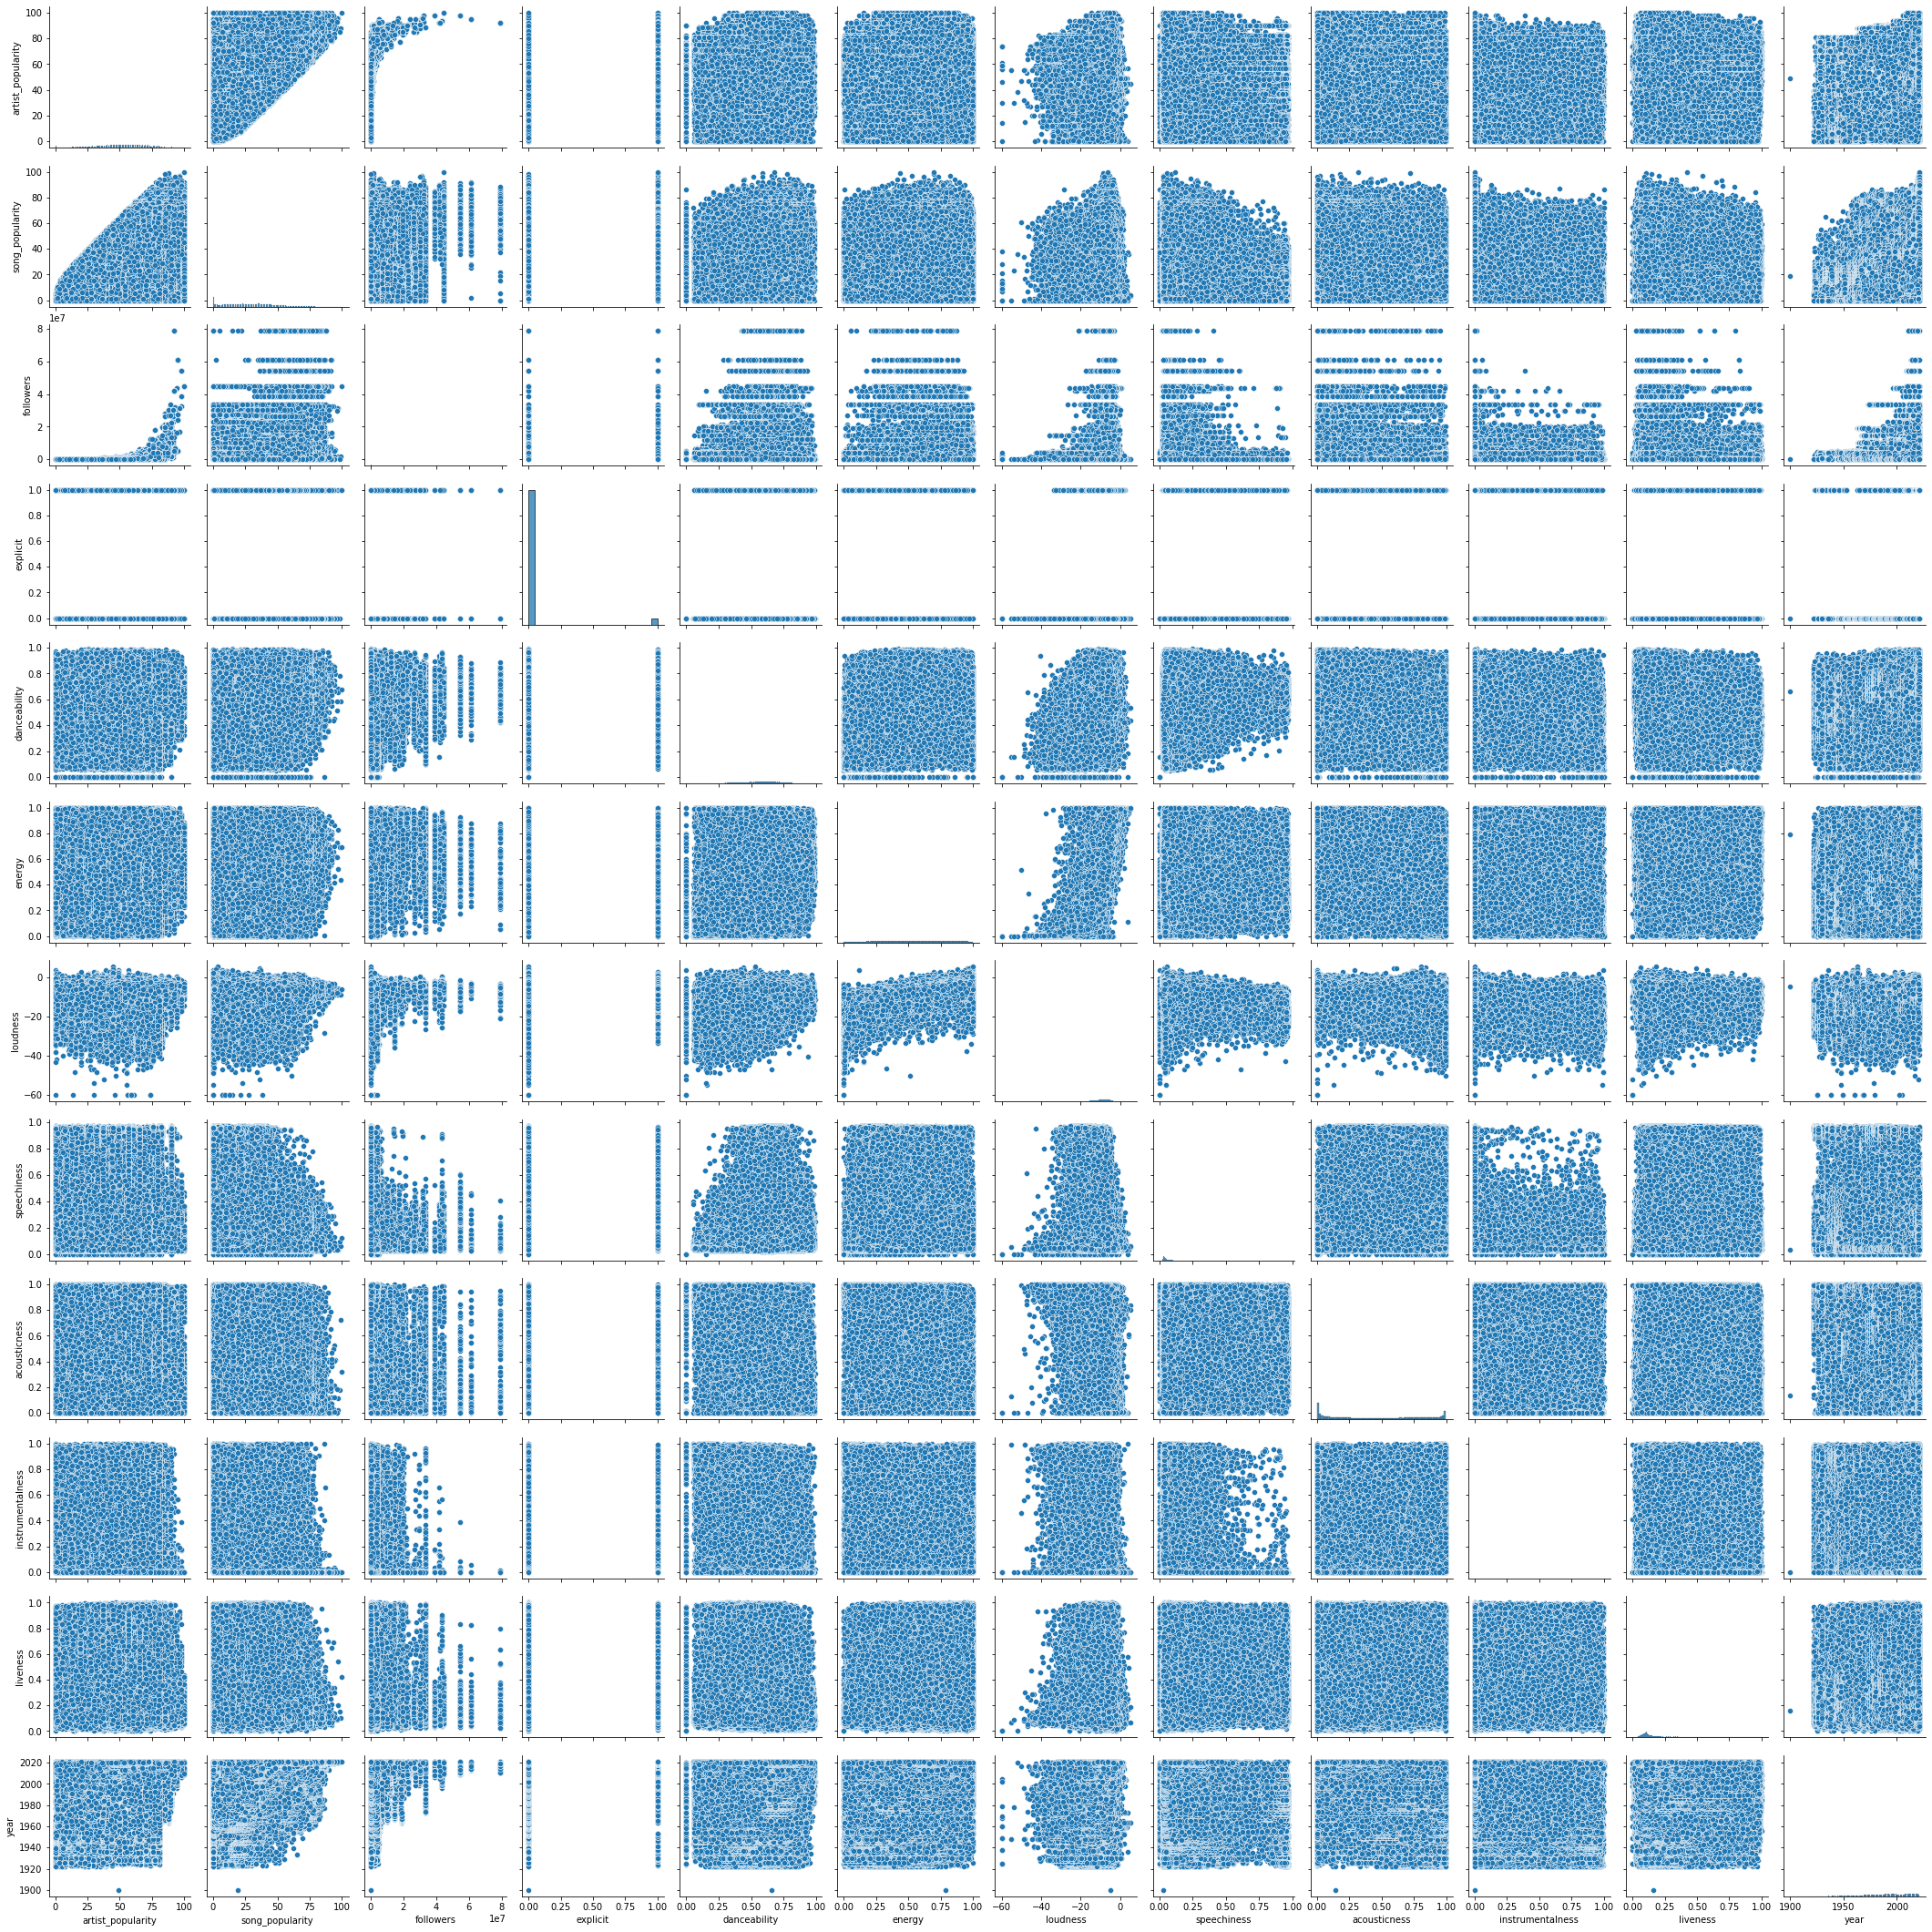

In [ ]:
#Reseting the index of the df and check to make sure all index values are unique
df = df.reset_index(drop=True)
df.index.is_unique

#Creating pairplot
sns.pairplot(df[['artist_popularity', 'song_popularity', 'followers', 'explicit',
                 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                 'instrumentalness', 'liveness', 'year']])

It's a little difficult to see some of these relationships but here are a couple interesting ones to point out:
1. There appears to be a fairly strong relationship between linear relationship between song_popularity and artist_popularity.
2. There is strong relationship between artist_popularity and followers.
3. Loudness and energy of a song seem to be positively related.

## Visualizations Relating to Year

Now, let's look at the distribution of the years the songs in the dataset were released.

In [ ]:
#Creating a df called year_dist that groups songs by year and counts the total number of songs in each year
year_dist = df.groupby(by='year')['song_id'].count().reset_index(name='count')

#Bar plot of year vs song frequency
fig = px.bar(year_dist, x='year', y='count', title='Frequency of Songs Released in Each Year')
fig.show()

It looks like most of the songs in our dataset were released in the late 90s. It is kind of surprising to see so many songs in the late 90s in comparison to the early 2000s.

## Most Popular Artists and Songs in the Dataset

Now, let's see which artists have the most songs in the dataset.

In [ ]:
#extract the first artist's id in the case that there are multiple artists featured on a song (assuming here that the first artist is the most popular one)
df['first_artist_id'] = df['id_artists'].str.split(',').str[0]

#extract first artist's name
df['first_artist'] = df['artists'].str.split(',').str[0]

#group by first artist's id and count the number of songs by each and sort them in descending order
top_w_features_df = df.groupby(by='first_artist_id')['song_id'].count().reset_index(name='count').sort_values(by='count', ascending=False)

#merge the artist's id with their name and just keep the name and count columns
top_df = top_w_features_df.merge(df, on='first_artist_id')[['first_artist', 'count']].drop_duplicates()

#print the df where artists have more than 150 songs in the dataset
top_df[top_df['count'] > 150][0:20]

first_artist  count
0                  Die drei ???   3856
3856          TKKG Retro-Archiv   2006
5862          Benjamin Blümchen   1485
7347            Bibi Blocksberg   1440
8787            Lata Mangeshkar   1086
9873              Bibi und Tina    900
10773          Francisco Canaro    866
11639  Tadeusz Dolega Mostowicz    838
12477              Fünf Freunde    812
13289           Ella Fitzgerald    770
14059             Die Originale    638
14697             Elvis Presley    628
15325             Frank Sinatra    626
15951             Mohammed Rafi    585
16536                     Globi    582
17118           Ignacio Corsini    504
17622                Pink Floyd    469
18091                 Bob Dylan    455
18546        The Rolling Stones    438
18984               Johnny Cash    434

Here, we see that the artists with the most songs in the dataset include Die drei ???, TKKG Retro-Archiv, Benjamin Blümchen, and Bibi Blocksberg, many artists I have never heard of. However, seeing artists like Bob Dylan, The Rolling Stones, and Pink Floyd isn't very suprising.

Now let's look at the most common artists that released songs in the last 10 years (from 2012 to now)

In [ ]:
#Extracting songs from the year 2012 and onwards, counting the frequency for each artist and sorting in descending order
top_w_features_df = df[df['year'] > 2011].groupby(by='first_artist_id')['song_id'].count().reset_index(name='count').sort_values(by='count', ascending=False)

#Merging the artist's name with their name and dropping duplicates
top_recent_df = top_w_features_df.merge(df, on='first_artist_id')[['first_artist', 'count', 'first_artist_id']].drop_duplicates()

top_recent_df[0:20]

first_artist  count         first_artist_id
0     Armin van Buuren    237  0SfsnGyD8FpIN4U4WCkBZ5
257                BTS    173  3Nrfpe0tUJi4K4DXYWgMUX
430       Taylor Swift    114  06HL4z0CvFAxyc27GXpf02
603         Pink Floyd    107  0k17h0D3J5VfsdmQ1iZtE9
1072               Jul     98  3IW7ScrzXmPvZhB27hmfgy
1170     One Direction     91  4AK6F7OLvEQ5QYCBNiQWHq
1267     The Beta Band     81  2LMR8u7DOMF0FBseDpTsRa
1349    Jorge & Mateus     77  1elUiq4X7pxej6FRlrEzjM
1475      Lana Del Rey     75  00FQb4jTyendYWaN8pK0wa
1552      Paul Carrack     75  0FFuvdY7fuiuTmHN9unYoz
1631        Eyal Golan     75  54jZWpivOTllo1afYNSx5U
1789      Wild Stylerz     69  1ZY4523hJlHABsolGReIwr
1858             TWICE     69  7n2Ycct7Beij7Dj7meI4X0
1927               PNL     68  3NH8t45zOTqzlZgBvZRjvB
1995    Taco Hemingway     66  7CJgLPEqiIRuneZSolpawQ
2061        The Weeknd     66  1Xyo4u8uXC1ZmMpatF05PJ
2127      Adam Gardner     62  7GbMHSUkqSEF3eeL4x7Nuy
2189      Arijit Singh     60  4YRxDV8wJFPHPTeXepOstw
2249             Drake     60  3TVXtAsR1Inumwj472S9r4
2329          The Cars     60  6DCIj8jNaNpBz8e5oKFPtp

Looking at the top 20 artists with the most hits since 2012, results are not that suprising, especially Drake, One Direction, Taylor Swift, and The Weeknd that have had really long musical careers and have consistently released music since 2012.

Now, let's see the distribution of song and artist popularity in the dataset. It would be really nice to see an even distribution of both but I'm expecting to see most artists and songs with a moderate popularity (between 30 and 70).

In [ ]:
#Grouping by artist_popularity and counting the total songs
artist_popularity_df = df.groupby(by='artist_popularity')['song_id'].count().reset_index(name='count').sort_values(by='count', ascending=False)

#Grouping by song_popularity and counting the total songs
song_popularity_df = df.groupby(by='song_popularity')['song_id'].count().reset_index(name='count').sort_values(by='count', ascending=False)

#Making a subplot see we can see the distribution of artist and song popularity side by side
#Source: https://plotly.com/python/subplots/
fig = make_subplots(rows=1, cols = 2, subplot_titles=['Artist Popularity Frequency', 'Song Popularity Frequency'])

fig.add_trace(go.Bar( 
                    x=artist_popularity_df['artist_popularity'].to_list(), 
                    y=artist_popularity_df['count'].to_list()), 
                    row=1, col=1)

fig.add_trace(go.Bar( 
             x=song_popularity_df['song_popularity'].to_list(), 
             y=song_popularity_df['count'].to_list()), 
             row=1, col=2)

fig.show()

As a result, we can see the artist popularity is almost distributed as expected since most artists have a popularity between 30 and 80.  However, I expected to see more popular songs in this dataset.  What was most shocking was to see how to artists and especially songs have a popularity of 0. We will drop the rows with a song_popularity of 0 later on.

Now let's see what the most popular songs are in the dataset.

In [ ]:
#Sorting by song_popularity and printing the top 15
df.sort_values(by='song_popularity', ascending=False)[0:15][['song_name', 'artists', 'genres', 'song_popularity', 'year', 'artist_popularity']]

song_name         artists  \
93803         drivers license  Olivia Rodrigo   
93804  Astronaut In The Ocean     Masked Wolf   
92810         Save Your Tears      The Weeknd   
92811               telepatía      Kali Uchis   
92813         Blinding Lights      The Weeknd   
92814            The Business          Tiësto   
92816  Heartbreak Anniversary          Giveon   
92817             WITHOUT YOU   The Kid LAROI   
91866                 Streets        Doja Cat   
92823               Good Days             SZA   
92826               positions   Ariana Grande   
92827            Hecha Pa' Mi            Boza   
93809                      Up         Cardi B   
93811                 Hold On   Justin Bieber   
91867        Watermelon Sugar    Harry Styles   

                                                  genres  song_popularity  \
93803                                 pop, post-teen pop               99   
93804                                 australian hip hop               98   
92810       canadian contemporary r&b, canadian pop, pop               97   
92811                                 colombian pop, pop               97   
92813       canadian contemporary r&b, canadian pop, pop               96   
92814  big room, brostep, dance pop, dutch edm, edm, ...               95   
92816                                           pop, r&b               94   
92817                                 australian hip hop               94   
91866                            dance pop, pop, pop rap               94   
92823                                  pop, pop rap, r&b               93   
92826                                 pop, post-teen pop               92   
92827                                            unknown               92   
93809                   pop, pop rap, post-teen pop, rap               92   
93811                   canadian pop, pop, post-teen pop               92   
91867                                 pop, post-teen pop               92   

       year  artist_popularity  
93803  2021               88.0  
93804  2021               85.0  
92810  2020               96.0  
92811  2020               88.0  
92813  2020               96.0  
92814  2020               87.0  
92816  2020               91.0  
92817  2020               90.0  
91866  2019               91.0  
92823  2020               88.0  
92826  2020               95.0  
92827  2020               78.0  
93809  2021               90.0  
93811  2021              100.0  
91867  2019               90.0

I'm not shocked to see these results since these were very popular song in 2021.  Notice from these results how all of the songs were released in the past couple of years and the artists are all very popularity (all have popularity score of over 80).

Now most popular artists by the dataset's artist_popularity.

In [ ]:
#Groupby artists, take mean popularity, and sort in descending order
df.groupby(by='first_artist')[['artist_popularity']].mean().reset_index().sort_values(by='artist_popularity', ascending=False)[0:15]

first_artist  artist_popularity
23806  Justin Bieber              100.0
12854          Drake               98.0
45643   Taylor Swift               98.0
4849       Bad Bunny               98.0
47746     The Weeknd               96.0
23567     Juice WRLD               96.0
4728             BTS               96.0
12932       Dua Lipa               95.0
3814   Ariana Grande               95.0
21084       J Balvin               95.0
33423    Myke Towers               95.0
48847   Travis Scott               94.0
14320         Eminem               94.0
10615         DaBaby               93.0
35926          Ozuna               93.0

These results are not shocking all, considering these were the most popular artists in 2021. I am a little surprised to see how popular Juice WRLD still is since he passed away in 2019.  I wonder if this influenced his popularity in any way?

## Genre Visualizations

Now let's look at the most popular categories. First, let's look at broad categories using a pie chart.

In [ ]:
#Making a list of all broad categories
broad_genres = []
for row in df['broad_genres']:
  row_list = row.split(', ')
  broad_genres += row_list

#Count the occurence of each genre and create a df showing each genre and its frequency
top_broad_genres = Counter(broad_genres).most_common(50)
df_top_broad_genres = pd.DataFrame(top_broad_genres, columns=['genre', 'frequency'])

fig = go.Figure(data=[go.Pie(labels=df_top_broad_genres['genre'], values=df_top_broad_genres['frequency'])])
fig.show()

It looks like our most popular category (making up 38.8% of the dataset) is pop. Songs classified as other are also popular, along with rock, unknown, latin, and classical.  Let me note again here that the difference between songs that are unknown and other is that songs that are 'unknown' did not consist any information about the genre in the raw dataset. Songs that are classified as 'other' had information in the dataset but we were unable to place them in a broad category.  We decided to keep these two categories separate because we didn't want to group together songs that could potentially be classified in other categories with songs that clearly could not be.  

Now, see what the most frequently occuring (non-broad) categories are. Since most songs fall under multiple categories, we'll use a word map to show which ones appear the most frequently.

CPU times: user 7.89 s, sys: 681 ms, total: 8.57 s
Wall time: 8.75 s


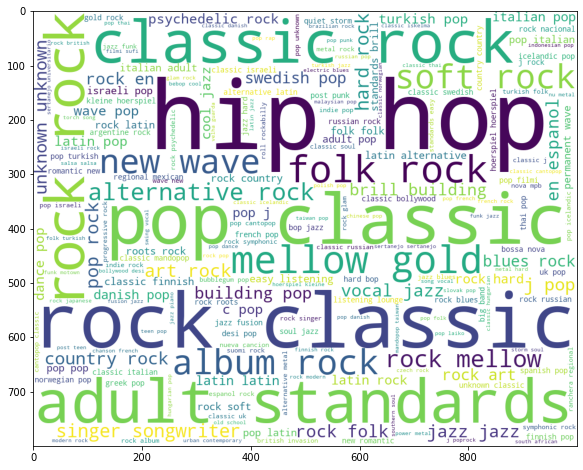

In [ ]:
%%time
#Create a list of all the genres
genres = []
for row in df['genres']:
  row_list = row.split(', ')
  genres += row_list

#Join the genres as a string and create the word cloud
genres_str = (" ").join(genres)
genres_wordcloud = wordcloud.WordCloud(width = 1000, height = 800, background_color='white').generate(genres_str)

plt.figure(figsize=(20,8))
plt.imshow(genres_wordcloud)

It looks like hip-hop, classic rock, adult standards, and pop are very frequently occuring.

## Have Explicit Lyrics Become More Common Over Time?

Our next visualization will plot the proportion of songs in the dataset are 'explicit' every year.  We expect this to steadily increase.

In [ ]:
#Group filter out songs that are explicit and not explicit, group them by year, and count their frequency
explicit_df = df[df['explicit'] == 1].groupby('year')['song_id'].count().reset_index().rename(columns={'song_id':'explicit'})
non_explicit_df = df[df['explicit'] == 0].groupby('year')['song_id'].count().reset_index().rename(columns={'song_id':'non-explicit'})

#Join the two dfs together to make it convenient for plotting
exp_join = explicit_df.merge(non_explicit_df, how='outer', on='year')

#Fill nulls with 0
exp_join = exp_join.fillna(0)

#Create a column 'percent_explicit' that is the proportion of explicit vs. non-explicit songs
exp_join['percent_explicit'] = round(exp_join['explicit'] / (exp_join['explicit'] + exp_join['non-explicit']), 5)

#Plot the proportion of explicit songs for every year
fig = px.bar(exp_join, x="year", y="percent_explicit",
             title='Percentage of Songs Every Year that are Explicit')
fig.show()

Wow. It appears the proportion of explicit vs non-explicit songs steadily increased starting from the 80's to the early 2010's but then increased dramatically after 2014/2015. I find it very shocking that more than a quarter of the songs released in 2021 were explicit.  One possible explanation for this could be maybe that certain genres started becoming more popular or songs with more abrusive language became more liked (or possibly a combination of both).

## What Genres Have Become More Popular Over the Years? 

Let's see what genres have become more popular over the years first looking at the mean song_popularity of every genre and then looking at the frequency of just pop, rock, rap, and country songs.

In [ ]:
#Grouping by year and genre and taking the average song_popularity
average_popularity_df = df.groupby(['year', 'broad_genres'])['song_popularity'].mean().reset_index()

#Excluding the categories other, unknown, and soundtrack
average_popularity_df = average_popularity_df[(average_popularity_df['broad_genres'] != 'other') & \
                                              (average_popularity_df['broad_genres'] != 'unknown') & \
                                              (average_popularity_df['broad_genres'] != 'soundtrack')
                                              ]

#Plot average song popular for each genre in each year
fig = px.line(average_popularity_df, x="year", y="song_popularity", color='broad_genres')
fig.show()

It looks like country, latin, r&b, and rap have the highest mean song_popularity. We're very surprised to see country, but I'm not as suprised by the others.

Now, let's focus on just comparing the frequencies of songs in pop, rock, country, and rap over the years. I have a feeling we'll see that rap songs have become more frequent and rock songs have decreased.

In [ ]:
#Filter only pop, rock, country, and rap songs and then groupby category and year and rename the frequency column
frequency_df = df[(df['broad_genres'] == 'pop') | (df['broad_genres'] == 'rock') | (df['broad_genres'] == 'country') | (df['broad_genres'] == 'rap')].groupby(['broad_genres', 'year'])['song_id'].count().reset_index().sort_values(by='year')
frequency_df = frequency_df.rename(columns={'song_id':'frequency'})

#Plot each year's number of the songs and how many belong to each genre. Hover over the plot to see more details about this
fig = px.bar(frequency_df, x="year", y='frequency', color='broad_genres', title="Frequency of Pop, Rock, Country, and Rap Songs Over the Years")
fig.show()

Notice much the frequency of rap songs increased over the years since the 1990's in comparison to the other genres. Also, look at how the frequency of rock songs steadily decreased. My predictions were correct although a expected more of a drastic increase in rap and decrease in rop.  It appears pop hasn't changed very much and if anything has become more steadily popular.  I'm also a little suprised to see that country songs are hardly popular in total makeup given their mean song popularity in the previous chart. It must be that country songs aren't released as often as the other categories, but when they are released they're usually very popular.

## Analysis of Top 10 Most Popular Songs of Every Year Since 2010

Let's take a look at the most popular songs since 2010!

In [ ]:
#Extracting songs that were released after 2009
recent_df = df[df['year'] > 2009]

#Making a list of every year after 2009 
years_list = recent_df.year.unique().tolist()

#Removing 2010 from the list
years_list.remove(2010)

#Filter songs only released in 2010 and take the top 10 most popular after sorting them in order of popularity
concat_df = recent_df[recent_df['year'] == 2010].sort_values(by='song_popularity', ascending=False).head(10)

#Do this for all other years and concatenate the df from each year with those from the previous years
for year in years_list:
  temp_df = recent_df[recent_df['year'] == year].sort_values(by='song_popularity', ascending=False).head(10)
  concat_df = pd.concat([temp_df, concat_df], axis=0)

#Rearranging the columns so they're easier to visualize
concat_df = concat_df[['year', 'song_name', 'artists', 'broad_genres', 'song_popularity', 'artist_popularity']]

Now, let's see the most top 10 most popular songs every year since 2010. We used the display function from the iPython library to make to make the tables were easier to visualize. I'm getting nostalgic just seeing some of these songs ...

In [ ]:
#Year by year print the df with the songs sorted in order to song popularity
for year in sorted(recent_df.year.unique().tolist()):
  print("Year: ", year)
  temp = concat_df[concat_df.year == year].sort_values(by='song_popularity', ascending=False).head(10)
  display(temp)
  print( )
  print( )

Year:  2010


year              song_name      artists broad_genres  \
83144   2010       Hey, Soul Sister        Train          pop   
156198  2010   Just the Way You Are   Bruno Mars          pop   
156197  2010    Talking to the Moon   Bruno Mars          pop   
83146   2010                TiK ToK        Kesha          pop   
83147   2010  I Can't Handle Change         Roar      unknown   
83149   2010        Please Don't Go  Mike Posner          rap   
83157   2010             Not Afraid       Eminem          rap   
83152   2010               Dynamite    Taio Cruz          rap   
83151   2010              The Spins   Mac Miller          rap   
83154   2010             Super Bass  Nicki Minaj          rap   

        song_popularity  artist_popularity  
83144                84               78.0  
156198               83               93.0  
156197               83               93.0  
83146                83               81.0  
83147                82               69.0  
83149                82               77.0  
83157                80               94.0  
83152                80               75.0  
83151                80               87.0  
83154                80               90.0



Year:  2011


year                  song_name                   artists  \
84076   2011            Pumped Up Kicks         Foster The People   
84077   2011                Tongue Tied                 Grouplove   
112648  2011           A Thousand Years           Christina Perri   
84082   2011                   Work Out                   J. Cole   
84081   2011                   Paradise                  Coldplay   
84084   2011           Someone Like You                     Adele   
84087   2011  Love You Like A Love Song  Selena Gomez & The Scene   
84090   2011        Rolling in the Deep                     Adele   
84088   2011        Levels - Radio Edit                    Avicii   
84097   2011              What the Hell             Avril Lavigne   

       broad_genres  song_popularity  artist_popularity  
84076           pop               85               78.0  
84077           pop               83               73.0  
112648          pop               81               75.0  
84082           rap               81               87.0  
84081           pop               81               89.0  
84084           pop               80               85.0  
84087           rap               79               71.0  
84090           pop               78               85.0  
84088           pop               78               85.0  
84097           pop               77               80.0



Year:  2012


year                         song_name                  artists  \
85054   2012  Can't Hold Us - feat. Ray Dalton  Macklemore & Ryan Lewis   
85055   2012              Locked out of Heaven               Bruno Mars   
85053   2012               When I Was Your Man               Bruno Mars   
85056   2012          What Makes You Beautiful            One Direction   
175623  2012                           Classic                     MKTO   
85061   2012                   Bubblegum Bitch                   MARINA   
85063   2012                            Demons          Imagine Dragons   
85059   2012                   Everybody Talks               Neon Trees   
85062   2012        Feel So Close - Radio Edit            Calvin Harris   
85069   2012                           Whistle                 Flo Rida   

       broad_genres  song_popularity  artist_popularity  
85054           rap               85               78.0  
85055           pop               85               93.0  
85053           pop               85               93.0  
85056           pop               84               90.0  
175623          rap               82               73.0  
85061           pop               82               78.0  
85063          rock               82               89.0  
85059           pop               82               73.0  
85062           pop               82               87.0  
85069           rap               80               83.0



Year:  2013


year                                 song_name            artists  \
86016  2013                           Sweater Weather  The Neighbourhood   
86018  2013                          Do I Wanna Know?     Arctic Monkeys   
86017  2013                                 All of Me        John Legend   
86019  2013  Why'd You Only Call Me When You're High?     Arctic Monkeys   
86021  2013                                Wake Me Up             Avicii   
86025  2013                                All I Want           Kodaline   
86027  2013                            Counting Stars        OneRepublic   
86023  2013                          Story of My Life      One Direction   
86029  2013                              Another Love          Tom Odell   
86035  2013                            Safe And Sound     Capital Cities   

      broad_genres  song_popularity  artist_popularity  
86016          pop               90               86.0  
86018        dance               87               87.0  
86017          pop               87               83.0  
86019        dance               86               87.0  
86021          pop               85               85.0  
86025          pop               84               76.0  
86027          pop               84               84.0  
86023          pop               84               90.0  
86029          pop               83               75.0  
86035          pop               82               69.0



Year:  2014


year          song_name        artists broad_genres  song_popularity  \
86988  2014         The Nights         Avicii          pop               86   
86989  2014     No Role Modelz        J. Cole          rap               85   
86990  2014         Photograph     Ed Sheeran          pop               85   
86993  2014  Thinking out Loud     Ed Sheeran          pop               84   
86991  2014  Take Me To Church         Hozier          pop               84   
86995  2014      Night Changes  One Direction          pop               83   
86997  2014             Summer  Calvin Harris          pop               83   
86999  2014       Stay With Me      Sam Smith          pop               83   
87007  2014             Shower        Becky G          rap               82   
87008  2014              Sugar       Maroon 5          pop               82   

       artist_popularity  
86988               85.0  
86989               87.0  
86990               92.0  
86993               92.0  
86991               82.0  
86995               90.0  
86997               87.0  
86999               88.0  
87007               82.0  
87008               91.0



Year:  2015


year                   song_name            artists broad_genres  \
87950  2015                Daddy Issues  The Neighbourhood          pop   
87949  2015                   The Hills         The Weeknd          pop   
87951  2015  The Less I Know The Better        Tame Impala        other   
87952  2015                Stressed Out  Twenty One Pilots         rock   
87953  2015               Electric Love              BØRNS          pop   
87956  2015               Love Yourself      Justin Bieber          pop   
87954  2015                   Play Date   Melanie Martinez          pop   
87965  2015          Can't Feel My Face         The Weeknd          pop   
87961  2015                        Ride  Twenty One Pilots         rock   
87963  2015              Wait a Minute!             WILLOW          pop   

       song_popularity  artist_popularity  
87950               87               86.0  
87949               87               96.0  
87951               86               83.0  
87952               86               86.0  
87953               86               75.0  
87956               84              100.0  
87954               84               82.0  
87965               82               96.0  
87961               82               86.0  
87963               82               75.0



Year:  2016


year             song_name            artists broad_genres  \
88938  2016            goosebumps       Travis Scott          rap   
88940  2016  Say You Won't Let Go       James Arthur          pop   
88939  2016           Train Wreck       James Arthur          pop   
88944  2016            Devil Eyes    Hippie Sabotage          rap   
88947  2016               Runaway             AURORA          pop   
88945  2016    That's What I Like         Bruno Mars          pop   
88948  2016   Line Without a Hook   Ricky Montgomery          pop   
88949  2016               Redbone   Childish Gambino          rap   
88958  2016              Heathens  Twenty One Pilots         rock   
88956  2016           Mr Loverman   Ricky Montgomery          pop   

       song_popularity  artist_popularity  
88938               88               94.0  
88940               87               86.0  
88939               87               86.0  
88944               86               77.0  
88947               84               79.0  
88945               84               93.0  
88948               84               76.0  
88949               84               81.0  
88958               83               86.0  
88956               83               76.0



Year:  2017


year                           song_name          artists broad_genres  \
89909  2017                            Believer  Imagine Dragons         rock   
89911  2017                             Perfect       Ed Sheeran          pop   
89910  2017                      Jocelyn Flores     XXXTENTACION          rap   
89912  2017                        Shape of You       Ed Sheeran          pop   
89916  2017                             Thunder  Imagine Dragons         rock   
89915  2017  Everybody Dies In Their Nightmares     XXXTENTACION          rap   
89918  2017                       XO Tour Llif3     Lil Uzi Vert          rap   
89924  2017                   Sign of the Times     Harry Styles          pop   
89932  2017                         Look At Me!     XXXTENTACION          rap   
89926  2017                              20 Min     Lil Uzi Vert          rap   

       song_popularity  artist_popularity  
89909               88               89.0  
89911               87               92.0  
89910               87               92.0  
89912               87               92.0  
89916               85               89.0  
89915               85               92.0  
89918               84               91.0  
89924               84               90.0  
89932               83               92.0  
89926               83               91.0



Year:  2018


year                 song_name        artists broad_genres  \
90901  2018              Lucid Dreams     Juice WRLD          rap   
90906  2018                SICKO MODE   Travis Scott          rap   
90904  2018                      SAD!   XXXTENTACION          rap   
90903  2018    All Girls Are The Same     Juice WRLD          rap   
90907  2018                      Hope   XXXTENTACION          rap   
90909  2018                   Snowman            Sia          pop   
90913  2018                 Moonlight   XXXTENTACION          rap   
90922  2018                   Falling  Trevor Daniel          rap   
90919  2018        Let Me Down Slowly  Alec Benjamin          pop   
90918  2018  SLOW DANCING IN THE DARK           Joji          pop   

       song_popularity  artist_popularity  
90901               88               96.0  
90906               87               94.0  
90904               87               92.0  
90903               87               96.0  
90907               86               92.0  
90909               86               90.0  
90913               85               92.0  
90922               85               77.0  
90919               85               80.0  
90918               85               85.0



Year:  2019


year          song_name          artists broad_genres  song_popularity  \
91866  2019            Streets         Doja Cat          rap               94   
91867  2019   Watermelon Sugar     Harry Styles          pop               92   
91869  2019  Someone You Loved    Lewis Capaldi          pop               90   
91870  2019            Circles      Post Malone          rap               89   
91872  2019             Arcade  Duncan Laurence          pop               89   
91884  2019          Adore You     Harry Styles          pop               88   
91882  2019       Dance Monkey      Tones And I          pop               88   
91880  2019            bad guy    Billie Eilish          pop               88   
91877  2019            The Box      Roddy Ricch          rap               88   
91875  2019           Memories         Maroon 5          pop               88   

       artist_popularity  
91866               91.0  
91867               90.0  
91869               86.0  
91870               93.0  
91872               80.0  
91884               90.0  
91882               81.0  
91880               92.0  
91877               88.0  
91875               91.0



Year:  2020


year               song_name        artists broad_genres  \
92810  2020         Save Your Tears     The Weeknd          pop   
92811  2020               telepatía     Kali Uchis          pop   
92813  2020         Blinding Lights     The Weeknd          pop   
92814  2020            The Business         Tiësto          pop   
92816  2020  Heartbreak Anniversary         Giveon          pop   
92817  2020             WITHOUT YOU  The Kid LAROI          rap   
92823  2020               Good Days            SZA          rap   
92826  2020               positions  Ariana Grande          pop   
92827  2020            Hecha Pa' Mi           Boza      unknown   
92832  2020      you broke me first     Tate McRae          pop   

       song_popularity  artist_popularity  
92810               97               96.0  
92811               97               88.0  
92813               96               96.0  
92814               95               87.0  
92816               94               91.0  
92817               94               90.0  
92823               93               88.0  
92826               92               95.0  
92827               92               78.0  
92832               91               83.0



Year:  2021


year                  song_name            artists broad_genres  \
93803  2021            drivers license     Olivia Rodrigo          pop   
93804  2021     Astronaut In The Ocean        Masked Wolf          rap   
93809  2021                         Up            Cardi B          rap   
93811  2021                    Hold On      Justin Bieber          pop   
93815  2021                What’s Next              Drake          rap   
93816  2021                 We're Good           Dua Lipa          pop   
93813  2021                        911               Sech          rap   
93822  2021                     Anyone      Justin Bieber          pop   
93820  2021                    deja vu     Olivia Rodrigo          pop   
93825  2021  Batom de Cereja - Ao Vivo  Israel & Rodolffo          pop   

       song_popularity  artist_popularity  
93803               99               88.0  
93804               98               85.0  
93809               92               90.0  
93811               92              100.0  
93815               91               98.0  
93816               91               95.0  
93813               91               89.0  
93822               90              100.0  
93820               90               88.0  
93825               89               80.0

Looking at the top 10 songs from every year, we notice several things:
1. Most of the songs are in English.
2. Many of the most popular songs are by the same artists.
3. It appears Bruno Mars and One Direction dominated the early 2010s and Travis Scott, the Weeknd, XXXTENTACION, and Juice WLRD were more popular in the later 2010s/early 2020s. \
4. The most popular songs from the early 2010s are mostly pop songs but more rap songs make the list in the second half of the decade.

Now, let's create a list of all the artists that make up this list so we can visualize which ones occur the most frequently.

In [ ]:
#Split on ',' so we can split up the featured artists in multi-artist songs
all_names = []
for name in concat_df.artists.tolist():
  all_names += name.split(',')

#Count the number of time each artist appears on the list
all_names = pd.DataFrame(Counter(all_names).most_common(100), columns=['artists', 'frequency'])

#Join with df_artists on the names so we can obtain the genres column in df_artists
all_names = all_names.merge(df_artists, left_on='artists', right_on='artists_name')

#Dropping duplicated columns
all_names = all_names.drop_duplicates(subset='artists', keep="first")

#Finding the broad category of the artists using the find_broad_category function
all_names['broad_genres'] = all_names['genres'].apply(lambda x: find_broad_category(x))

In [ ]:
#Creating a bar plot showing each artist and their frequency making the top 10 list. We grouped each genre together as well.
fig = px.bar(all_names, x="artists", y="frequency", color='broad_genres', \
      title="Number of Times Artists Made to it the Year-End Top 10 (2010-2021)")
fig.show()

As a result of the above chart, it appears Bruno Mars, Ed Sheeran, Justin Bieber, The Weeknd, XXXTENTACION, Travis Scott, One Direction, Imagine Dragons, Twenty One Pilots, Avicii, and Arctic Monkeys appear most frequently.

Now, let's look at the frequency of each genre over the decade.

In [ ]:
#Group by genre and count each instance
recent_top_genre = all_names.groupby('broad_genres')['id_artists'].count().reset_index().rename(columns={'id_artists':'frequency'})

#Plot each genre against its frequency
fig = px.bar(recent_top_genre, x="broad_genres", y="frequency", color='broad_genres', \
      title="Genres from Top 10 Songs (2010-2021)")
fig.show()

As we can see, an overwhelming majority of the most popular songs in the last decade are pop songs, but rap songs are quite popular as well.

# Section 5: Model 1 - Regression : Preprocessing

In this next section, we will process the data and prepare it for training. This involves selecting the features we want to include in the model, splitting training and testing data, one hot encoding categorical features, and standardizing numerical features.  This preprocessing will be for our regression models.  We'll have a separate processing section for our Classification model since this will involve different transformations

## Data Transformation

First, let's select our features from our dataframe and remove rows where the song popularity is 0.

In [ ]:
df = df[df['song_popularity'] > 0]

In [ ]:
#extracting features from df
X = df[['artist_popularity', 'explicit', 'followers', 'duration_ms', 'danceability', \
        'energy', 'loudness', 'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', \
        'valence', 'tempo', 'time_signature', 'year', 'broad_genres'
        ]]

y = df[['song_popularity']]

Now let's split the data into training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

One-hot encode the broad genres for both the training and test sets.

In [ ]:
#Create dummies
one_hot_encoded_train_genre = pd.get_dummies(X_train['broad_genres'], prefix=None, prefix_sep='_')
one_hot_encoded_test_genre = pd.get_dummies(X_test['broad_genres'], prefix=None, prefix_sep='_')

#Drop non-encoded column
X_train = X_train.drop(columns=['broad_genres'])
X_test = X_test.drop(columns=['broad_genres'])

#Add one-hot-encoded values to X_train and X_test
X_train[list(one_hot_encoded_train_genre.columns)] = one_hot_encoded_train_genre
X_test[list(one_hot_encoded_test_genre.columns)] = one_hot_encoded_test_genre

Now let's separate the numerical and categorical training data so we can standardize the numerical data.

In [ ]:
numerical_train_df = X_train[['artist_popularity', 'duration_ms', 'followers', 'key', 'danceability', \
                  'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', \
                  'valence', 'tempo', 'time_signature', 'year'
                  ]]

numerical_test_df = X_test[['artist_popularity', 'duration_ms', 'followers', 'key', 'danceability', \
                  'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', \
                  'valence', 'tempo', 'time_signature', 'year'
                  ]]

categorical_train_df = X_train[['explicit', 'mode'] + list(one_hot_encoded_train_genre.columns)]

categorical_test_df = X_test[['explicit', 'mode'] + list(one_hot_encoded_test_genre.columns)]

Now, let's standardize the numerical data using StandardScalar. We chose to use StandardScalar because it's the preferred scaling method for most regression and classification problems, especially the models we'll use here.

In [ ]:
scale = StandardScaler()
scale.fit(numerical_train_df)

X_train = scale.transform(numerical_train_df)
X_test = scale.transform(numerical_test_df)

Then, let's concatenate the categorical columns and numerical columns.

In [ ]:
X_train = np.concatenate((X_train, categorical_train_df.to_numpy()), axis=1)
X_test = np.concatenate((X_test, categorical_test_df.to_numpy()), axis=1)

# Section 6: Model 1 - Regression: Predicting Song Popularity + Evaluation

In this section, we'll train our first step of models.  These are our continuous models that aim to predict song_popularity based on the features we selected in the previous section.

## Linear Regression - Baseline Model

First, we'll use basic linear regression with no regularization for our baseline model. A baseline model is essentially a simple model that acts as a reference in a machine learning project. Its main function is to contextualize the results of trained models. While baseline models usually lack complexity and may have little predictive power, it is a good opener for our analysis.  Linear Regression works by finding the weights (or coefficients) that are used in the linear equation that best explains the correlation between y and all the independent variables

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train, y_train)
y_pred = linreg.predict(X_test)
r_squared = linreg.score(X_test, y_test)

We can evaluate the Linear Regression model using its r-squared, a goodness-of-fit measure that explains how much variation of song_popularity is explained its features. An r-squared closer to 1 is a better fit and an r-squared closer to 0 is a worse fit.

In [ ]:
r_squared

0.5268548597990204

An r-squared of .5268 means that the model explains 52.68% of the variation in song_popularity can be explained by the features we selected. This isn't great but it's a decent starting point.



Let's look at a couple other metrics including:
1. Mean Absolute Error (MAE) - which calculates the absolute difference between the actual and predicted values.
2. Mean Squared Error (MSE) - the squared difference between the actual and predicted values
3. Adjusted R^2 - version of R^2 that shows whether or not adding extra features improves the regression model (something R^2 fails to explain)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print("MAE",mean_absolute_error(y_test, y_pred))
print("MSE",mean_squared_error(y_test,y_pred))
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r_squared = 1 - ((1-r_squared)*((n - 1)/(n-p-1)))
print('Adjusted R^2', adjusted_r_squared)

MAE 8.829711652709536
MSE 128.97419533053707
Adjusted R^2 0.5266581010613651


Our MAE and MSE are somewhat low and the adjust R^2 is not very different from regular R^2, showing that are our additional features are not contributing to misleading R^2.

Now let's take a look at each feature's coefficient.

In [ ]:
coefficients = pd.DataFrame(data={
    'Attribute': ['artist_popularity', 'duration_ms', 'followers', 'key', 'danceability', \
                  'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', \
                  'valence', 'tempo', 'time_signature', 'year'
                  ] + ['explicit', 'mode'] + list(one_hot_encoded_train_genre.columns),
    'Importance': linreg.coef_[0]
})
coefficients = coefficients.sort_values(by='Importance', ascending=False)

We split this into 2 graphs so it's easier to see.

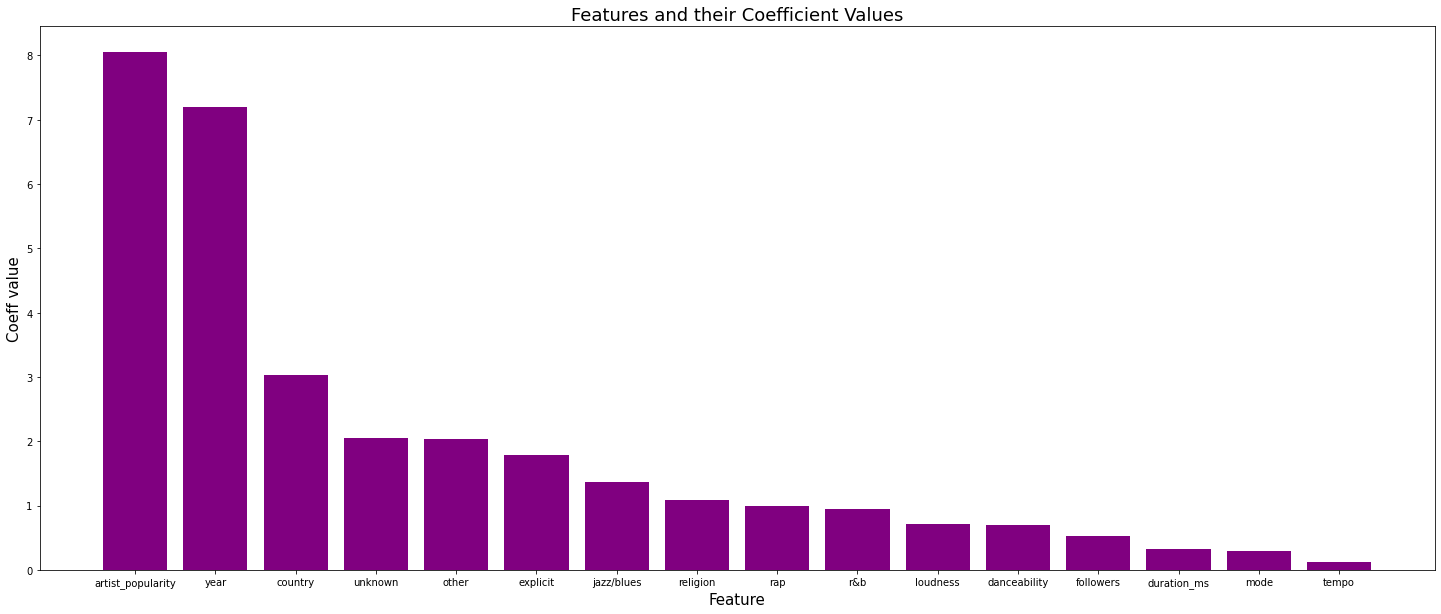

In [ ]:
plt.rcParams["figure.figsize"] = (25,10)
plt.bar(coefficients['Attribute'][0:16], coefficients['Importance'][0:16], color='purple')
plt.ylabel('Coeff value', fontSize=15)
plt.xlabel('Feature', fontSize=15)
plt.title('Features and their Coefficient Values', fontSize=18)
plt.show()

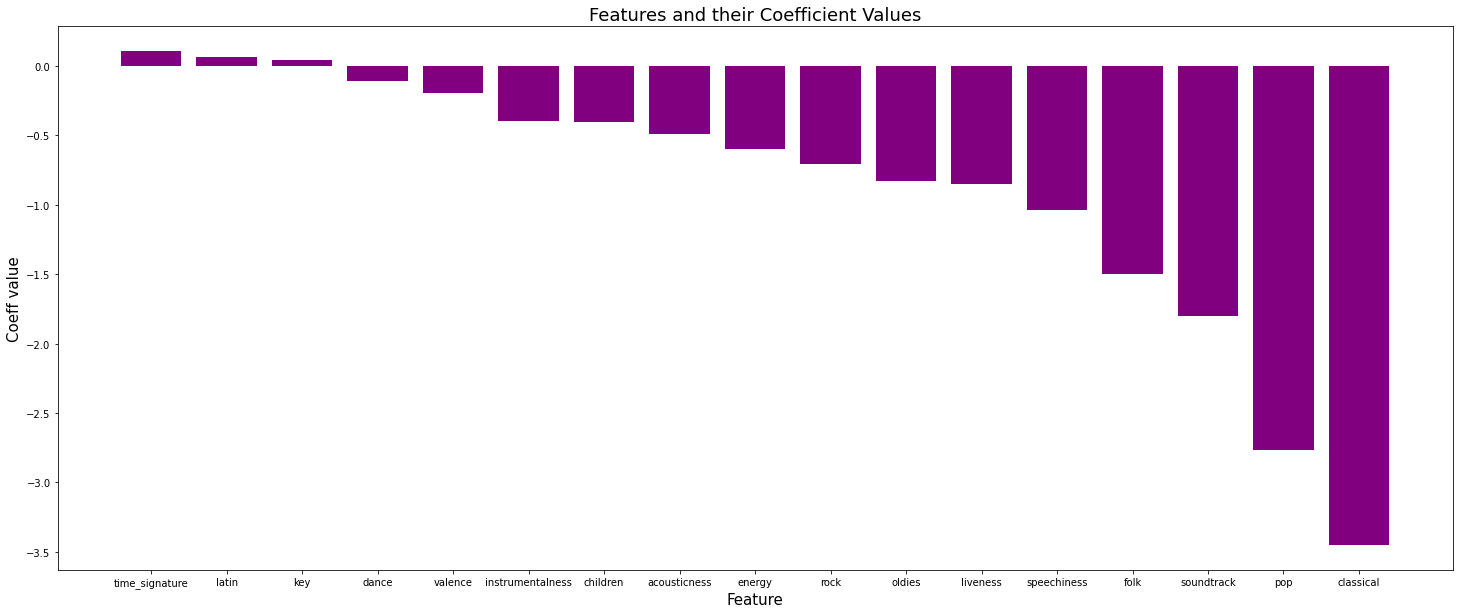

In [ ]:
plt.rcParams["figure.figsize"] = (25,10)
plt.bar(coefficients['Attribute'][16:33], coefficients['Importance'][16:33], color='purple')
plt.ylabel('Coeff value', fontSize=15)
plt.xlabel('Feature', fontSize=15)
plt.title('Features and their Coefficient Values', fontSize=18)
plt.show()

It appears what features influence the model's output the most are artist_popularity, year, country, folk, pop, and classical.

## Linear Regression with PCA

Now let's perform PCA to see if this helps reduce the complexity and noise in our model. PCA in linear regression has been used to serve two basic goals. The first one is performed on datasets where the number of predictor variables is too high. It has been a method of dimensionality reduction along with Partial Least Squares Regression.

In our case PCA is useful because we can select the features that are most important for the model, which could boost our R^2. Once we fit PCA on our training data, we can find the explained variance ratio, which is the percentage of variance that is explained by each feature. We can then find the cumulative sum of each and plot these.  We should take the number of features where the line falls flat.

In [ ]:
from sklearn.decomposition import PCA

#fit PCA over X_train
X = StandardScaler().fit_transform(X_train)

#Fit on X
pca = PCA().fit(X)

#Derive the explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = explained_variance_ratios.cumsum()

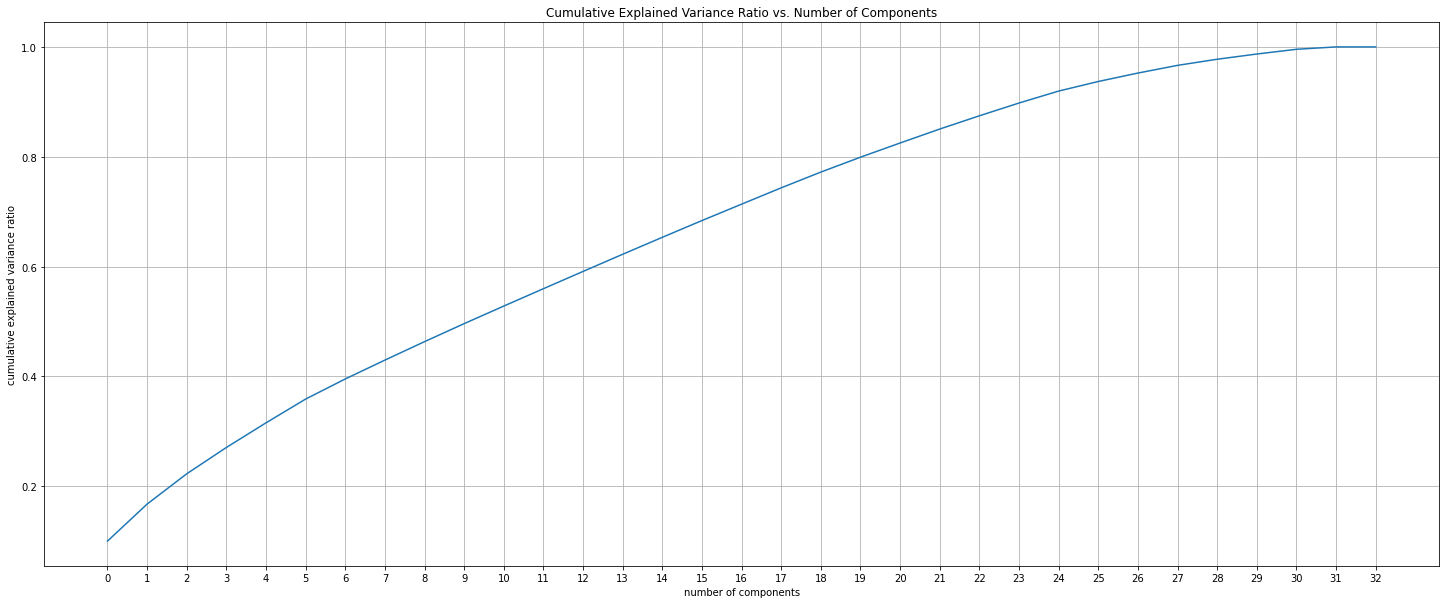

In [ ]:
plt.plot(np.arange(0,X.shape[1]), cum_evr)

plt.ylabel('cumulative explained variance ratio')
plt.xlabel('number of components')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.xticks(np.arange(0, X.shape[1], 1))
plt.grid()

plt.show()

Here, we see that the line falls flat at 31, so we'll reduce our data to 31 features and train another linear regression model.

In [ ]:
#Fit and transform X_test and X_train with PCA
pca = PCA(n_components=31)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#Re-train and re-fit linear regression with X_train_pca and X_test_pca
linreg = LinearRegression().fit(X_train_pca, y_train)
y_pred = linreg.predict(X_train_pca)
r_squared = linreg.score(X_test_pca, y_test)

In [ ]:
r_squared

0.5268631776700149

We see that this didn't improve our r^2 they way we hoped. Now we'll consider other models other than linear regression.

## XGBoost Regressor

We decided to next try XGBoost to solve our regression problem. 

Extreme Gradient Boosting, or XGBoost for short, is an efficient open-source implementation of the gradient boosting algorithm. Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.

We chose XGBoost because it is known to yield very high r^2 scores.  XGBoost is a type of decision tree algorithm that uses Gradient Boosting, which sequentially builds stronger models from weaker models. While it is considered more accurate than linear baseline model, its limitation is that it is more prone to overfitting. 

Source: https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/

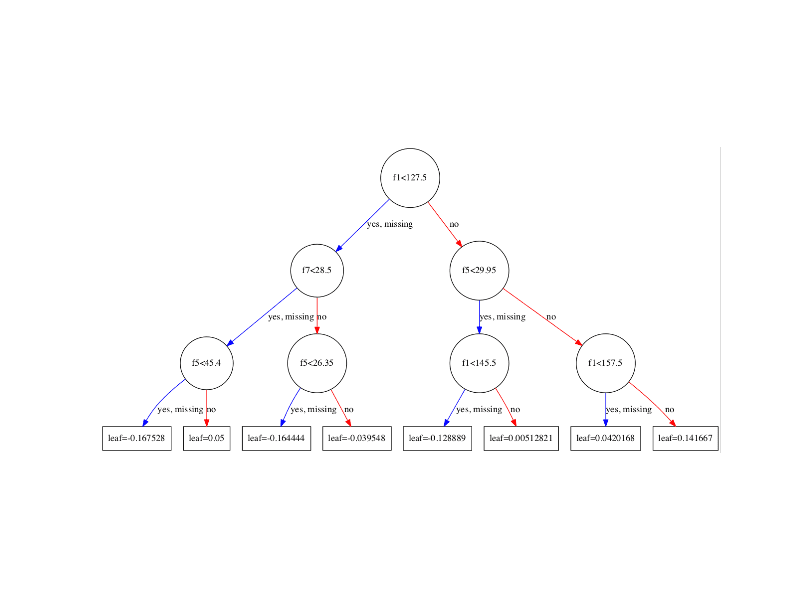

In [ ]:
%%time
import xgboost as xgb

xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train,y_train)

[03:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 26.2 s, sys: 30.5 ms, total: 26.2 s
Wall time: 27.1 s


XGBRegressor()

In [ ]:
y_pred = xg_reg.predict(X_test)

Now, let's look at the metrics.

In [ ]:
print('r^2', xg_reg.score(X_test, y_test))
print("MAE",mean_absolute_error(y_test, y_pred))
print("MSE",mean_squared_error(y_test,y_pred))

r^2 0.5786476500730153
MAE 8.273634792941486
MSE 114.85604662319898


Notice in this model, the r^2, MAE, and MSE are all a bit higher.  We're a bit surprised that XGBoost didn't have remarkable better results compared to linear regression.

## Random Forest Regressor

Last, we wanted to try the Random Forest Regressor. 

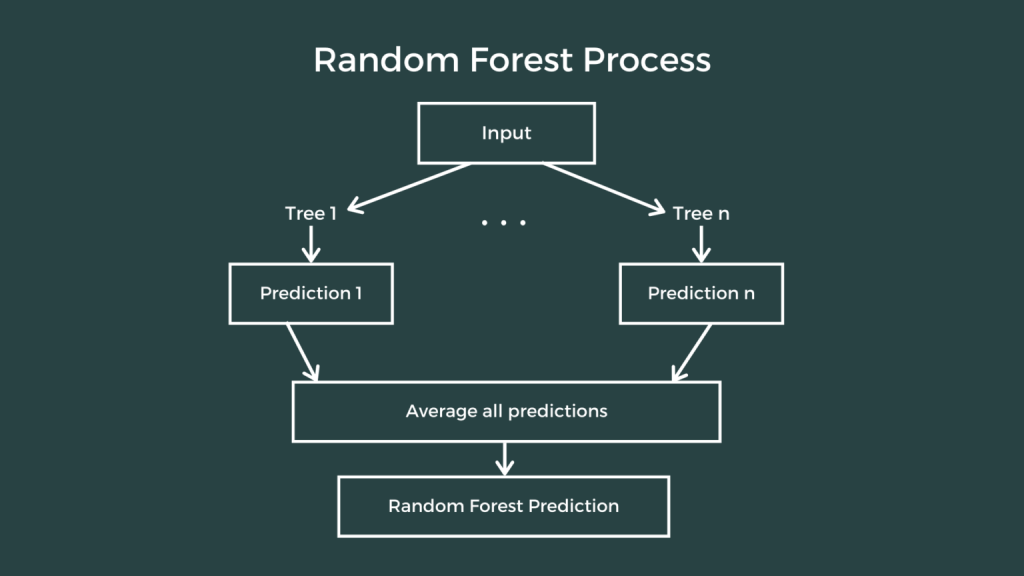

Source: https://medium.com/@theclickreader/random-forest-regression-explained-with-implementation-in-python-3dad88caf165

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Since overfitting could be a limitation of XGBoost regressor Random Forest seems like a good alternative. Random Forest uses bagging techniques to reduce variance by leaving some features out.  At the same time, it also creates randomness by repeating some observations. Random Forest works by growing multiple decision trees based on our model features and takes the average when making a decision.

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

CPU times: user 8min 46s, sys: 2.19 s, total: 8min 48s
Wall time: 9min 8s


RandomForestRegressor()

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print('r^2', rf.score(X_test, y_test))
print("MAE",mean_absolute_error(y_test, y_pred))
print("MSE",mean_squared_error(y_test,y_pred))

r^2 0.6683045100528731
MAE 7.214093653222919
MSE 90.41656624123215


As a result, Random Forest is by far our best model for predicting song_popularity with highest r^2 and lowest MAE and MSE.

Now, we would like to convert this into a classification problem.  We realize it's very difficult to predict precise song_popularity, so in the next section, we'll put our data into 10 different groups by song_popularity and try to accurately predict the class each song.

# Section 7: Model 1 - Classification: Preprocessing

In this section, we'll prepare the data for our classification model.  This will be similar to our preprocessing for our regression model but we will pick different features, find our classes, address class imbalance, and remove outliers for each class. First, let's find our classes. We'll have 10 classes. Each one will be based on song_popularity.

In [ ]:
def determine_class(x):
  if 0 <= x <= 10:
    return 'group 1'
  elif 10 < x <= 20:
    return 'group 2'
  elif 20 < x <= 30:
    return 'group 3'
  elif 30 < x <= 40:
    return 'group 4'
  elif 40 < x <= 50:
    return 'group 5'
  elif 50 < x <= 60:
    return 'group 6'
  elif 60 < x <= 70:
    return 'group 7'
  elif 70 < x <= 80:
    return 'group 8'
  elif 80 < x <= 90:
    return 'group 9'
  elif 90 < x <= 100:
    return 'group 10'

In [ ]:
#creating column called class based on a song's popularity
df['class'] = df['song_popularity'].apply(lambda x: determine_class(x))

Let's see the distribution of our classes.

In [ ]:
df['class'].value_counts()

group 3     85779
group 4     84595
group 2     67997
group 5     57833
group 1     52767
group 6     31559
group 7     12436
group 8      3539
group 9       413
group 10       23
Name: class, dtype: int64

It looks like there's a lot of class imbalance. Let's first look at removing outliers in each group (especially the ones that consist the most data points) and then we'll address these imbalances.

Since our last model wasn't super accurate, let's attempt to remove outliers for each group.  We can look at the variance of our most numerical important features for predicting song_popularity - artist_popularity and year

In [ ]:
for group in ['group 1', 'group 2', 'group 3', 'group 4', 'group 5', 'group 6', 'group 7', 'group 8', 'group 9', 'group 10']:
  print('{}'.format(group))
  print('var artist_popularity', df[df['class'] == group]['artist_popularity'].var())
  print('var year', df[df['class'] == group]['year'].var())
  print( )

group 1
var artist_popularity 328.2990483585647
var year 455.10139890488557

group 2
var artist_popularity 246.9599522624908
var year 239.19880756964045

group 3
var artist_popularity 253.57915349342395
var year 215.77536529149586

group 4
var artist_popularity 268.5004732135873
var year 205.01862803384154

group 5
var artist_popularity 171.09237405357146
var year 200.9021159288744

group 6
var artist_popularity 134.88929988218698
var year 196.3460569743654

group 7
var artist_popularity 108.52941945915481
var year 209.04739669116327

group 8
var artist_popularity 97.62185537843597
var year 209.70896068694933

group 9
var artist_popularity 59.36987235242953
var year 123.75587108300618

group 10
var artist_popularity 26.209486166007903
var year 0.35968379446640303



It looks like our classes with the most data points (groups 1-8) have the most variation in their artist_popularity and year.  Let's look at removing the outliers for these columns.  Since these are somewhat extreme, let's remove the bottom 20 percentile and top 80 percentile values for classes 1-8.

In [ ]:
def remove_outliers(df, group):
  df = df[(df['class'] == group)]
  return df[(df['artist_popularity'] > df['artist_popularity'].quantile(.20)) & \
   (df['artist_popularity'] < df['artist_popularity'].quantile(.80)) & (df['year'] < df['year'].quantile(.80)) & \
   (df['year'] > df['year'].quantile(.20))]

In [ ]:
df_g1 = remove_outliers(df, 'group 1')
df_g2 = remove_outliers(df, 'group 2')
df_g3 = remove_outliers(df, 'group 3')
df_g4 = remove_outliers(df, 'group 4')
df_g5 = remove_outliers(df, 'group 5')
df_g6 = remove_outliers(df, 'group 6')
df_g7 = remove_outliers(df, 'group 7')
df_g8 = remove_outliers(df, 'group 8')
df_outliers_removed = pd.concat([df_g1, df_g2, df_g3, df_g4, df_g5, df_g6, df_g7, df_g8])

In [ ]:
df = pd.concat([df_outliers_removed, 
                df[df['class'] == 'group 9'],
                df[df['class'] == 'group 10']
                ])

In [ ]:
df['class'].value_counts()

group 3     29047
group 4     29042
group 2     23561
group 5     19664
group 1     18583
group 6      9723
group 7      3817
group 8      1152
group 9       413
group 10       23
Name: class, dtype: int64

Let's our data is still imbalanced but atleast we were able to get rid of a lot of outliers. Now let's check our variances.

In [ ]:
for group in ['group 1', 'group 2', 'group 3', 'group 4', 'group 5', 'group 6', 'group 7', 'group 8', 'group 9', 'group 10']:
  print('{}'.format(group))
  print('var artist_popularity', df[df['class'] == group]['artist_popularity'].var())
  print('var year', df[df['class'] == group]['year'].var())
  print( )

group 1
var artist_popularity 82.17259818650818
var year 107.58491417546682

group 2
var artist_popularity 51.27685065079419
var year 57.881345553992745

group 3
var artist_popularity 56.5995733465005
var year 50.70576320662505

group 4
var artist_popularity 60.15418726485496
var year 48.29681584559189

group 5
var artist_popularity 42.888704985660134
var year 40.39120063788836

group 6
var artist_popularity 30.949916048330152
var year 34.67312435559421

group 7
var artist_popularity 21.096547004491107
var year 36.22080752607913

group 8
var artist_popularity 24.197723597837626
var year 32.41895634231103

group 9
var artist_popularity 59.36987235242953
var year 123.75587108300618

group 10
var artist_popularity 26.209486166007903
var year 0.35968379446640303



We still have quite a bit of variance in group 1 but this still looks a lot better now. Now, let's extract our columns.

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df[['artist_popularity', 'explicit', 'followers', 'duration_ms', 'danceability', \
        'energy', 'loudness', 'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', \
        'valence', 'tempo', 'time_signature', 'year', 'broad_genres'
        ]]

y = df[['class']]
y = LabelEncoder().fit_transform(y)

Then, one hot encode our categorical variables.

In [ ]:
one_hot_encoded_genre = pd.get_dummies(X['broad_genres'], prefix=None, prefix_sep='_', 
     dummy_na=False, columns=None, 
     sparse=False, drop_first=False, 
     dtype=None)
X = X.drop(columns=['broad_genres'])
X[list(one_hot_encoded_genre.columns)] = one_hot_encoded_genre

Now we're going to use SMOTE (Synthetic Minority Oversampling Technique), which increases the number of samples in every class so that all classes have the same number of data points as the class with the greatest number of samples. It works by creating new samples in every class that are similar to those that already exist. It does this by drawing a line between a data points and another one close to it and then creating a new data point along that line.

Source: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
%%time
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X, y)

CPU times: user 53.9 s, sys: 3.53 s, total: 57.4 s
Wall time: 53.2 s


In [ ]:
pd.DataFrame(y_resampled).value_counts()

0    29047
1    29047
2    29047
3    29047
4    29047
5    29047
6    29047
7    29047
8    29047
9    29047
dtype: int64

Now we see that every class has 29,047 data points. Let's now split our data into testing and training sets exactly as we've done in the previous section.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

numerical_train_df = X_train[['artist_popularity', 'duration_ms', 'followers', 'key', 'danceability', \
                  'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', \
                  'valence', 'tempo', 'time_signature', 'year'
                  ]]

numerical_test_df = X_test[['artist_popularity', 'duration_ms', 'followers', 'key', 'danceability', \
                  'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', \
                  'valence', 'tempo', 'time_signature', 'year'
                  ]]


categorical_train_df = X_train[['explicit', 'mode'] + list(one_hot_encoded_genre.columns)]

categorical_test_df = X_test[['explicit', 'mode'] + list(one_hot_encoded_genre.columns)]

scale = StandardScaler()
scale.fit(numerical_train_df)

X_train = scale.transform(numerical_train_df)
X_test = scale.transform(numerical_test_df)

X_train = np.concatenate((X_train, categorical_train_df.to_numpy()), axis=1)
X_test = np.concatenate((X_test, categorical_test_df.to_numpy()), axis=1)

# Section 8: Model 1 - Classification: Predicting Song Popularity + Evaluation

## KNN

Let's try to use the K-Nearest Neighbors Algorithm.  This algorithm works by placing all training points on a graph. Then, for each testing point we find the k closest training points and classify the testing point as the most frequently occurring class out those training points.  We wanted to try KNN because we haven't tried a clustering algorithm yet and KNN usually works very well in classification.  While we think this could be a descent model, we don't think it will be the best model because KNN doesn't work very well when there are a lot of features in the data.  It also took about 5 minutes for the algorithm to load. Here's an example visualization to illustrate how KNN works:

Source: https://towardsdatascience.com/knn-k-nearest-neighbors-1-a4707b24bd1d

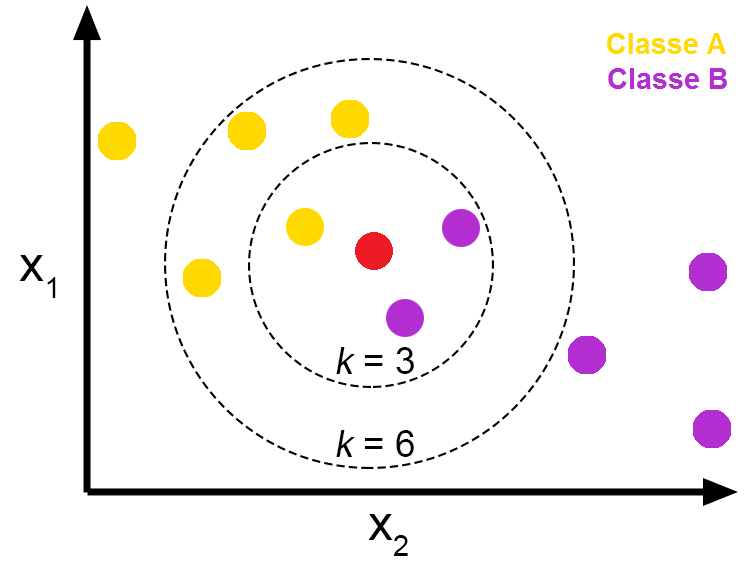

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
knn.score(X_test, y_test)

0.6687437601129205

We got an accuracy of 66.87%, which is decent, but I still think we can do better than this.  We can definitely find another classification model that is faster and more accurate than this.

## Random Forest Classifier

Next, we'll look at Random Forest Classifier. 

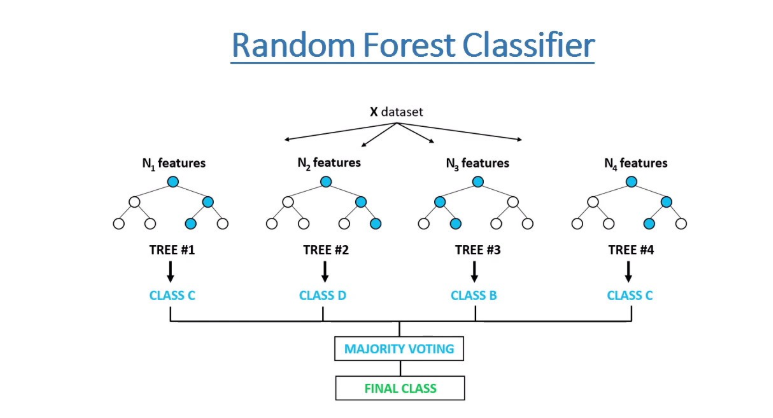

Source: https://medium.com/analytics-vidhya/random-forest-classifier-and-its-hyperparameters-8467bec755f6

Since this model worked best for our regression problem, we were curious to see how it performed in our classification problem. We also used Random Forest because it's quicker than KNN, which in our use case would be very slow since we have a somewhat large number of features.  Random Forest uses bagging techniques to reduce variance by leaving some features out.  At the same time, it also creates randomness by repeating some observations. The algorithm essentially creates a 'forest' a decision trees and then picks a class based on majority vote.

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

CPU times: user 1min 49s, sys: 565 ms, total: 1min 50s
Wall time: 1min 58s


RandomForestClassifier()

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.7970014115054911

Hooray, we have an accuracy of 79.7%! This is our best result! Now let's check the precision, recall, and f1 score of our model. I set average='macro' to calculate the metrics for each of the 10 classes and not take label imbalance into account because our classes are perfectly balanced.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print('f1 score', f1_score(y_test, y_pred, average='macro'))
print('precision', precision_score(y_test, y_pred, average='macro'))
print('recall', recall_score(y_test, y_pred, average='macro'))

f1 score 0.7931395280220623
precision 0.7950239851176452
recall 0.795570346779884


As we see, all three values are very close to the accuracy. Note, recall is the highest out of the three, meaning our model is good at correctly predicting the true labels. Let's define the other metrics.  Precision finds the ratio between true positives all all other positives. F-1 score is the harmonic mean of the precision and recall.

Now let's try to tune the hyperparameters and see if we can get a better model. Note, when we tried using GridSearchCV our RAM session crashed, so were going to manually change a couple hyperparameters and see what happens. First, let's see what the default parameters we used in our initial model are.

In [ ]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Let's change n_estimators to 250 and the criterion to entropy.

In [ ]:
%%time

clf_updated = RandomForestClassifier(criterion='entropy', n_estimators=250)
clf_updated.classes_fit(X_train, y_train)

CPU times: user 8min 33s, sys: 4.72 s, total: 8min 38s
Wall time: 8min 42s


RandomForestClassifier(criterion='entropy', n_estimators=250)

In [ ]:
y_pred = clf_updated.predict(X_test)

In [ ]:
clf_updated.score(X_test, y_test)

0.8008228044204221

Our accuracy improved by 1 percent. Let's check the other metrics

In [ ]:
print('f1 score', f1_score(y_test, y_pred, average='macro'))
print('precision', precision_score(y_test, y_pred, average='macro'))
print('recall', recall_score(y_test, y_pred, average='macro'))

f1 score 0.797248831760043
precision 0.7992613726912284
recall 0.8004269000001832


It took almost 8 times longer to run the model with the enhanced hyperparameters and only increased in accuracy by one percent.  We want to try k-Fold Cross Validation now but we will use the old model since it's much faster. We'll use 5 folds because this will be equivalent to how we split the data in the previous sections (training on 4/5 of the data and testing on 1/5). Cross Validation allows us to iteratively train and test on different parts of the dataset. This allows us to ensure that our model isn't overfitting and training multiple times on unseen data. Here is a visual to show how it works.

Source: https://pub.towardsai.net/k-fold-cross-validation-for-machine-learning-models-918f6ccfd6d

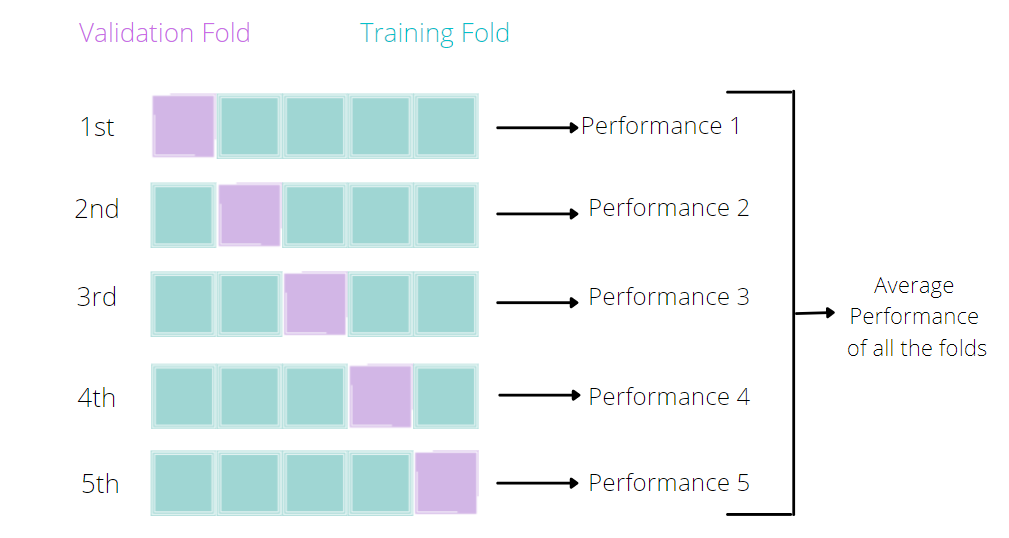

In [ ]:
%%time
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
print(cross_val_score(clf, X_resampled, y_resampled, cv=5, scoring='accuracy'))

[0.7451544  0.77999449 0.80159741 0.80622784 0.80318105]
CPU times: user 8min 33s, sys: 5.33 s, total: 8min 38s
Wall time: 8min 57s


As we can see our model doesn't overfit since the accuracy scores are all very close to each other.

Now let's create a confusion matrix. A confusion matrix is a table that is used to define the performance of a classification algorithm. A confusion matrix visualizes and summarizes the performance of a classification algorithm. In our case, will use the confusion matrix to see what classes Random Forest was good at predicting and not so good at predicting.

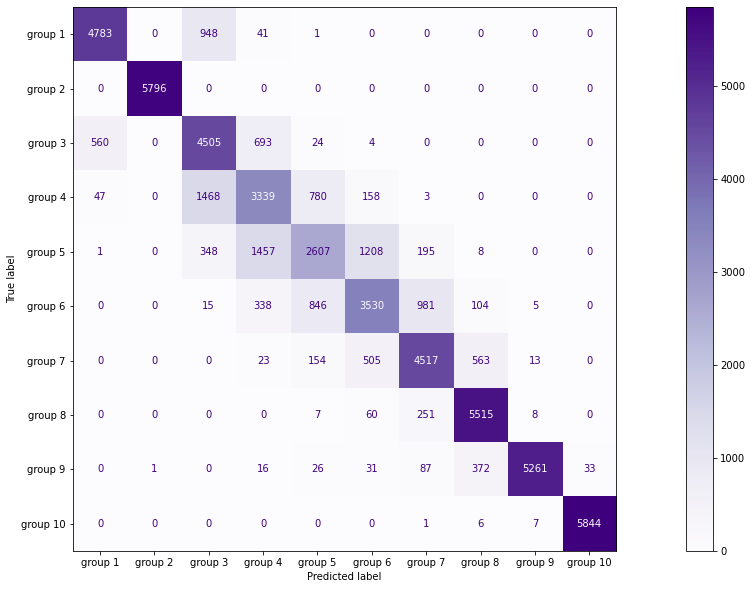

In [ ]:
from sklearn.metrics import plot_confusion_matrix

classes = ['group 1', 'group 2', 'group 3', 'group 4', 'group 5', 'group 6', 'group 7', 'group 8', 'group 9', 'group 10']


disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Purples,
                                 values_format = '.5g')

As we can see, the model had the easiest time predicting data 
points that fell in group 10 and group 2 and had the most difficulty with groups 4 to 6. It appears pretty common for predicted classes to be one before or after its true class.

# Section 9: Model 2: Song Recommendation

In this section, we'll build our second model - the Recommendation System. First, we'll preprocess the dataset by one-hot-encoding the broad_genres column and then we'll normalize the data and load it into the model.  This model with use Euclidean distance to find the distance between the float and integer features.  Data points that are closest in distance to the inputted song will be printed. 

## Updating df


In [ ]:
# getting df from right after the clearning process
# because the two models we have have different requirements for df.
df = df_copy

In [ ]:
# add genres into consideration, similar to section 6
one_hot_encoded_genre = pd.get_dummies(df['broad_genres'], prefix=None, prefix_sep='_')
df[list(one_hot_encoded_genre.columns)] = one_hot_encoded_genre

In [ ]:
# check df
df.head(5)

song_name         artists broad_genres  \
93803         drivers license  Olivia Rodrigo          pop   
93804  Astronaut In The Ocean     Masked Wolf          rap   
92810         Save Your Tears      The Weeknd          pop   
92811               telepatía      Kali Uchis          pop   
92813         Blinding Lights      The Weeknd          pop   

                                             genres  song_popularity  \
93803                            pop, post-teen pop               99   
93804                            australian hip hop               98   
92810  canadian contemporary r&b, canadian pop, pop               97   
92811                            colombian pop, pop               97   
92813  canadian contemporary r&b, canadian pop, pop               96   

       artist_popularity   followers                 song_id  \
93803               88.0   1444702.0  7lPN2DXiMsVn7XUKtOW1CS   
93804               85.0    177401.0  3Ofmpyhv5UAQ70mENzB277   
92810               96.0  31308207.0  5QO79kh1waicV47BqGRL3g   
92811               88.0   1698014.0  6tDDoYIxWvMLTdKpjFkc1B   
92813               96.0  31308207.0  0VjIjW4GlUZAMYd2vXMi3b   

                   id_artists  duration_ms  explicit  danceability  energy  \
93803  1McMsnEElThX1knmY4oliG       242014         1         0.585   0.436   
93804  1uU7g3DNSbsu0QjSEqZtEd       132780         0         0.778   0.695   
92810  1Xyo4u8uXC1ZmMpatF05PJ       215627         1         0.680   0.826   
92811  1U1el3k54VvEUzo3ybLPlM       160191         0         0.653   0.524   
92813  1Xyo4u8uXC1ZmMpatF05PJ       200040         0         0.514   0.730   

       key  loudness  mode  speechiness  acousticness  instrumentalness  \
93803   10    -8.761     1       0.0601       0.72100          0.000013   
93804    4    -6.865     0       0.0913       0.17500          0.000000   
92810    0    -5.487     1       0.0309       0.02120          0.000012   
92811   11    -9.016     0       0.0502       0.11200          0.000000   
92813    1    -5.934     1       0.0598       0.00146          0.000095   

       liveness  valence    tempo  time_signature  year  
93803    0.1050    0.132  143.874               4  2021  
93804    0.1500    0.472  149.996               4  2021  
92810    0.5430    0.644  118.051               4  2020  
92811    0.2030    0.553   83.970               4  2020  
92813    0.0897    0.334  171.005               4  2020

## Normalize Dataset

Before building the model, first we normalize or scale the dataset. For scaling it we are using MinMaxScaler of Scikit-learn library. 
For that, I selected all the columns with int and float datatypes.
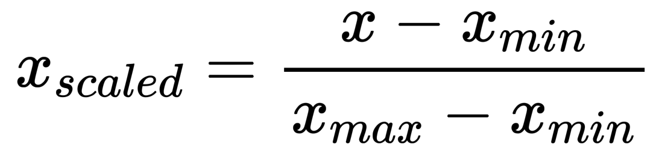

In [ ]:
# import library
from sklearn.preprocessing import MinMaxScaler
# select numerical data
datatypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
normalization = df.select_dtypes(include=datatypes)
# apply minmax scaler
for col in normalization.columns:
    MinMaxScaler(col)

In [ ]:
#check normarization
normalization

song_popularity  artist_popularity   followers  duration_ms  explicit  \
93803                99               88.0   1444702.0       242014         1   
93804                98               85.0    177401.0       132780         0   
92810                97               96.0  31308207.0       215627         1   
92811                97               88.0   1698014.0       160191         0   
92813                96               96.0  31308207.0       200040         0   
...                 ...                ...         ...          ...       ...   
121824                0               18.0        30.0       146900         0   
121823                0               18.0        30.0       127800         0   
17218                 0               35.0    190912.0       178733         0   
17220                 0                0.0         2.0       193567         0   
17222                 0               47.0    458624.0       196160         0   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
93803          0.585  0.4360   10    -8.761     1       0.0601       0.72100   
93804          0.778  0.6950    4    -6.865     0       0.0913       0.17500   
92810          0.680  0.8260    0    -5.487     1       0.0309       0.02120   
92811          0.653  0.5240   11    -9.016     0       0.0502       0.11200   
92813          0.514  0.7300    1    -5.934     1       0.0598       0.00146   
...              ...     ...  ...       ...   ...          ...           ...   
121824         0.714  0.2390    0   -20.573     1       0.9520       0.50100   
121823         0.696  0.1990    6   -25.164     1       0.9610       0.64200   
17218          0.293  0.0264   10   -21.316     1       0.0461       0.99500   
17220          0.797  0.1740    3   -14.661     1       0.1030       0.97900   
17222          0.308  0.2400   10   -15.955     1       0.0400       0.99500   

        instrumentalness  liveness  valence    tempo  time_signature  year  
93803           0.000013    0.1050    0.132  143.874               4  2021  
93804           0.000000    0.1500    0.472  149.996               4  2021  
92810           0.000012    0.5430    0.644  118.051               4  2020  
92811           0.000000    0.2030    0.553   83.970               4  2020  
92813           0.000095    0.0897    0.334  171.005               4  2020  
...                  ...       ...      ...      ...             ...   ...  
121824          0.000000    0.3690    0.588  114.996               1  1936  
121823          0.000000    0.2990    0.709   90.216               3  1936  
17218           0.545000    0.1700    0.445   80.020               4  1943  
17220           0.052800    0.3290    0.742   88.359               4  1943  
17222           0.274000    0.1090    0.253   71.629               4  1943  

[419823 rows x 18 columns]

In [ ]:
# check df
df

song_name  \
93803                              drivers license   
93804                       Astronaut In The Ocean   
92810                              Save Your Tears   
92811                                    telepatía   
92813                              Blinding Lights   
...                                            ...   
121824   Chapter 13.3 - Drugie życie doktora Murka   
121823   Chapter 2.11 - Drugie życie doktora Murka   
17218   Jinhen Karna Tha Dil Abaad (From "Naukar")   
17220                     Blue Lou - 1988 Remaster   
17222                      Mor Maramer Batayantale   

                                       artists broad_genres  \
93803                           Olivia Rodrigo          pop   
93804                              Masked Wolf          rap   
92810                               The Weeknd          pop   
92811                               Kali Uchis          pop   
92813                               The Weeknd          pop   
...                                        ...          ...   
121824                Tadeusz Dolega Mostowicz      unknown   
121823                Tadeusz Dolega Mostowicz      unknown   
17218                               Noor Jehan          pop   
17220   Børge Roger Henrichsen og hans kvintet      unknown   
17222                             Hemant Kumar          pop   

                                                   genres  song_popularity  \
93803                                  pop, post-teen pop               99   
93804                                  australian hip hop               98   
92810        canadian contemporary r&b, canadian pop, pop               97   
92811                                  colombian pop, pop               97   
92813        canadian contemporary r&b, canadian pop, pop               96   
...                                                   ...              ...   
121824                                            unknown                0   
121823                                            unknown                0   
17218   classic bollywood, classic pakistani pop, film...                0   
17220                                             unknown                0   
17222   classic bollywood, classic pakistani pop, film...                0   

        artist_popularity   followers                 song_id  \
93803                88.0   1444702.0  7lPN2DXiMsVn7XUKtOW1CS   
93804                85.0    177401.0  3Ofmpyhv5UAQ70mENzB277   
92810                96.0  31308207.0  5QO79kh1waicV47BqGRL3g   
92811                88.0   1698014.0  6tDDoYIxWvMLTdKpjFkc1B   
92813                96.0  31308207.0  0VjIjW4GlUZAMYd2vXMi3b   
...                   ...         ...                     ...   
121824               18.0        30.0  2ptjeVZfBdS8d6lC3TSMJY   
121823               18.0        30.0  2pfcWjwj9wqLeKm1rR3Cxy   
17218                35.0    190912.0  2xPgD421w3ZtgCBrP2P1Ia   
17220                 0.0         2.0  2yLLE8IH40gZMPXojOB5jJ   
17222                47.0    458624.0  30vyZgP8qTabLafaLYOsrB   

                    id_artists  duration_ms  explicit  danceability  energy  \
93803   1McMsnEElThX1knmY4oliG       242014         1         0.585  0.4360   
93804   1uU7g3DNSbsu0QjSEqZtEd       132780         0         0.778  0.6950   
92810   1Xyo4u8uXC1ZmMpatF05PJ       215627         1         0.680  0.8260   
92811   1U1el3k54VvEUzo3ybLPlM       160191         0         0.653  0.5240   
92813   1Xyo4u8uXC1ZmMpatF05PJ       200040         0         0.514  0.7300   
...                        ...          ...       ...           ...     ...   
121824  4eeMulNeqpZGBxybCxZOdC       146900         0         0.714  0.2390   
121823  4eeMulNeqpZGBxybCxZOdC       127800         0         0.696  0.1990   
17218   0LruguA5aIP6yvLUIkxANh       178733         0         0.293  0.0264   
17220   1ypsg7Hx1oHZ0JAJ5w61yK       193567         0         0.797  0.1740   
17222   02Um2HIOrUdsy3wqPBZwsj       196160     

## Recommndation Function

In [ ]:
# here we are allowing recommendations from the same artist, 
# and also having a function not allowing recommendations from the same artist.

class Spotify_Recommendation():
    def __init__(self, dataset):
        self.dataset = dataset
    # allowing same artists
    def recommend_allow_same(self, input_song, artist, amount=1):
        distance = []
        # finding the input song in df
        song = self.dataset[((self.dataset.song_name.str.lower() == input_song.lower()) & (self.dataset.artists.str.lower() == artist.lower()))].head(1).values[0]
        # finding all possible recs in df
        rec = self.dataset[(self.dataset.song_name.str.lower() != input_song.lower())]
        # appying tqdm to create a progress bar
        for input_song in tqdm(rec.values):
            d = 0
            for col in np.arange(len(rec.columns)):
                # excluding all the string columns, 
                # additionally leaving out year, time signature
                if not col in [0, 1, 2, 3, 7, 8, 22, 23]:
                  # here we're doing squared difference
                  # not using cosine similarity because 
                  # everytime we call cosine_similarity(normalization) 
                  # the runtime crashes
                  d = d + (float(song[col]) - float(input_song[col]))**2
            distance.append(d)
        # add the column distance to the rec df
        rec['distance'] = distance
        # sort songs by distance from original song
        rec = rec.sort_values('distance')
        # select columns 
        columns = ['artists', 'song_name']
        return rec[columns][:amount]

    # not allowing songs from the same artist
    def recommend_dont_allow_same(self, input_song, artist, amount=1):
        distance = []
        # finding the input song in df
        song = self.dataset[((self.dataset.song_name.str.lower() == input_song.lower()) & (self.dataset.artists.str.lower() == artist.lower()))].head(1).values[0]
        # finding all possible recs in df
        rec = self.dataset[(self.dataset.song_name.str.lower() != input_song.lower()) & ((self.dataset.artists.str.lower()) != (artist.lower()))]
        # applying tqdm to create a progress bar
        for input_song in tqdm(rec.values):
            d = 0
            for col in np.arange(len(rec.columns)):
                # excluding all the string columns, 
                # additionally leaving out year, time signature
                if not col in [0, 1, 2, 3, 7, 8, 22, 23]:
                  # here we're doing squared difference, 
                  # not using cosine similarity because 
                  # everytime we call cosine_similarity(normalization) 
                  # the runtime crashes
                  d = d + (float(song[col]) - float(input_song[col]))**2
            distance.append(d)
        # add the column distance to the rec df
        rec['distance'] = distance
        # sort songs by distance from original song
        rec = rec.sort_values('distance')
        # select columns 
        columns = ['artists', 'song_name']
        # remove duplicates
        rec = rec.drop_duplicates(subset = 'artists', keep = 'first')
        return rec[columns][:amount]

## Examples

### **SICKO MODE** by Travis Scott

In [ ]:
# allowing songs from the same artist to pop up
Spotify_Recommendation(df).recommend_allow_same("SICKO MODE", "Travis Scott", 10)

100%|██████████| 419822/419822 [00:41<00:00, 10223.30it/s]


artists                                          song_name
114875  Travis Scott                              STOP TRYING TO BE GOD
89370   Travis Scott                             through the late night
504785     Sam Smith              Out of Our Heads - Tom Bruckner Remix
89615   Travis Scott                                           way back
88637      Sam Smith  Writing's On The Wall - From "Spectre" Soundtrack
91073   Travis Scott                                         STARGAZING
88051   Travis Scott                                           Antidote
218758     Sam Smith                                        I Feel Love
87454      Sam Smith                                        Lay Me Down
88938   Travis Scott                                         goosebumps

In [ ]:
# only allowing songs from different artists
Spotify_Recommendation(df).recommend_dont_allow_same("SICKO MODE", "Travis Scott", 10)

100%|██████████| 419790/419790 [00:42<00:00, 9792.61it/s] 


artists                                  song_name
504785              Sam Smith      Out of Our Heads - Tom Bruckner Remix
210908                KAROL G                                  Casi Nada
75942   Red Hot Chili Peppers                                      Dosed
91169                 Cardi B                               Bodak Yellow
406012                   ZAYN                                   iT's YoU
92016              Juice WRLD                                      Empty
436693              Lady Gaga                                       Hair
303708         Kendrick Lamar  Swimming Pools (Drank) - Extended Version
158194               Anuel AA                                  Na' Nuevo
481279        Sebastian Yatra                           Love You Forever

### **Die For You** by The Weeknd

In [ ]:
# allowing songs from the same artist to pop up
Spotify_Recommendation(df).recommend_allow_same("Die For You", "The Weeknd", 10)

100%|██████████| 419821/419821 [00:45<00:00, 9132.27it/s] 


artists                                          song_name
357221  The Weeknd                                            Outside
357210  The Weeknd                                         Initiation
85979   The Weeknd                                       Twenty Eight
89296   The Weeknd                                            Secrets
88553   The Weeknd                                          Shameless
131570  The Weeknd                                    Love In The Sky
87056   The Weeknd  Earned It (Fifty Shades Of Grey) - From The "F...
294055  The Weeknd                                           Montreal
89203   The Weeknd                                      Party Monster
87985   The Weeknd                                              Often

In [ ]:
# only allowing songs from different artists
Spotify_Recommendation(df).recommend_dont_allow_same("Die For You", "The Weeknd", 10)

100%|██████████| 419756/419756 [00:46<00:00, 9006.63it/s]


artists                      song_name
86756               BTS                         Coffee
88990       Post Malone                Feeling Whitney
89126         Bad Bunny                       Soy Peor
75441          Maroon 5  She Will Be Loved - Radio Mix
89096        Marshmello                          Alone
405907     Shawn Mendes                    Running Low
89053        Bruno Mars           Versace on the Floor
456409         Coldplay                  Everyday Life
129179            Queen       Thank God It's Christmas
90959   Imagine Dragons                       Bad Liar

### **Young and Beautiful** by Lana Del Rey

In [ ]:
# allowing songs from the same artist to pop up
Spotify_Recommendation(df).recommend_allow_same("Young And Beautiful", "Lana Del Rey", 10)

100%|██████████| 419820/419820 [00:43<00:00, 9754.93it/s] 


artists                    song_name
118567  Lana Del Rey         Dark But Just A Game
293994  Lana Del Rey                      Bel Air
156876  Lana Del Rey              Gods & Monsters
87546   Lana Del Rey          Pretty When You Cry
245087  Lana Del Rey  This Is What Makes Us Girls
263764  Lana Del Rey                Body Electric
294951  Lana Del Rey               In My Feelings
245082  Lana Del Rey           Million Dollar Man
131442  Lana Del Rey               Burning Desire
487459  Lana Del Rey     Video Games - Radio Edit

In [ ]:
# only allowing songs from different artists
Spotify_Recommendation(df).recommend_dont_allow_same("Young And Beautiful", "Lana Del Rey", 10)

100%|██████████| 419744/419744 [00:44<00:00, 9392.48it/s] 


artists                              song_name
437255  Henrique & Juliano          Não To Valendo Nada (Ao Vivo)
90963         Charlie Puth                              Attention
85761         Romeo Santos                   La Bella Y La Bestia
384639             Nirvana  Something In The Way - Devonshire Mix
114172       Fifth Harmony                           Sledgehammer
210989        Paulo Londra                                  Relax
84082              J. Cole                               Work Out
530993             Badshah                       She Move It Like
112248         Chris Brown                                  Crawl
334339           Green Day                    Last Night on Earth

### **Hey Jude** by The Beatles

In [ ]:
# allowing songs from the same artist to pop up
Spotify_Recommendation(df).recommend_allow_same("Hey Jude", "The Beatles", 10)

100%|██████████| 419814/419814 [00:57<00:00, 7330.02it/s]


artists                                       song_name
117070  The Beatles          Lucy In The Sky With Diamonds - Take 1
41629   The Beatles                     Yer Blues - Remastered 2009
41540   The Beatles                 Dear Prudence - Remastered 2009
40667   The Beatles                  Blue Jay Way - Remastered 2009
43718   The Beatles                    Dig A Pony - Remastered 2009
42564   The Beatles  You Never Give Me Your Money - Remastered 2009
43491   The Beatles                     Let It Be - Remastered 2009
70109   The Beatles                 Real Love - Anthology 2 Version
41645   The Beatles              Don't Pass Me By - Remastered 2009
73852   The Beatles                     Let It Be - Remastered 2015

In [ ]:
# only allowing songs from different artists
Spotify_Recommendation(df).recommend_dont_allow_same("Hey Jude", "The Beatles", 10)

100%|██████████| 419483/419483 [00:48<00:00, 8621.08it/s] 


artists                         song_name
229995                Sia                   Clap Your Hands
583710             Avicii                         Liar Liar
114750        Demi Lovato               Tell Me You Love Me
437802   Marília Mendonça  Esse Cara Aqui do Lado - Ao Vivo
53592               AC/DC                Have a Drink on Me
264091        Linkin Park                   Until It's Gone
86306   Twenty One Pilots                          Migraine
299669     "Guns N Roses"           Mama Kin - Live Version
55503     Michael Jackson       P.Y.T. (Pretty Young Thing)
531792        Neha Kakkar                 Khyaal Rakhya Kar

### **White Ferrari** by Frank Ocean

In [ ]:
# allowing songs from the same artist to pop up
Spotify_Recommendation(df).recommend_allow_same("White Ferrari", "Frank Ocean", 10)

100%|██████████| 419822/419822 [00:42<00:00, 9812.34it/s] 


artists        song_name
88996      Frank Ocean              Ivy
89102      Frank Ocean     Self Control
415039  Kelly Clarkson  Catch My Breath
114774     Frank Ocean         Provider
84432      Frank Ocean        Swim Good
89500      Frank Ocean             Solo
77630   Kelly Clarkson        Breakaway
303879     Frank Ocean       Sweet Life
85149      Frank Ocean             Lost
186984  Kelly Clarkson  Mr. Know It All

In [ ]:
# only allowing songs from different artists
Spotify_Recommendation(df).recommend_dont_allow_same("White Ferrari", "Frank Ocean", 10)

100%|██████████| 419793/419793 [00:43<00:00, 9689.42it/s]


artists                                          song_name
415039   Kelly Clarkson                                    Catch My Breath
210838             CNCO                                     Volverte a Ver
85033   Cartel De Santa                                         El Hornazo
344799    Lewis Capaldi  when the party's over - Recorded at Spotify St...
313243       Anne-Marie                           Perfect To Me - Acoustic
575625       Liam Payne                         Strip That Down - Acoustic
286050       MC Kevinho                                      O Grave Bater
71067         Daft Punk                                              Fresh
335455              EXO                                     My Turn to Cry
86610             Lorde                                     Buzzcut Season

## Analysis

 It seems like the recommender provides mostly songs from the same artist when allowed to do so. It usually returns songs of the artist we provided when we allow one artist to appear multiple times in the recommendations.


 When it comes to recommending songs from different artists(excluding the input artist), the recommender generally provide songs of similar style, as illustrated above.



 

# Section 10: Conclusion

**Conclusion**

In this project, we examined a spotify dataset with 586.672 songs from 1921 to 2021.  We first imported and cleaned the data. Second, we conducted exploratory data analysis and visualized some inferences we made such as:


1.   **Correlation Matrix**  - We found that song_popularity is most positively correlated with the artist's popularity and the year is was released and most negatively correlated with the instrumentalness and acousticness of a song.
2.   **Distribution of songs by release year**  - It looks like most of the songs in our dataset were released in the late 90s. I'm a little surprisd to see so many songs in the late 90s in comparison to the early 2000s.
3. **Song and Artist popularity distribution** - The artist popularity is a normal distribution with most artists having a popularity between 30 and 80. Songs popularity not that much as most of them have 0 popularity and the higher you go to the popularity scale, the less songs you find.
4. **Song genre pie chart** - the most popular category is pop by far (38.7%), followed by latin (9.18%).
5. **Explicit songs distribution**  - Explicit songs were very rare before the 90s with less than 2% of total songs out there. Then they gradually increased. The most notable increase happened in 2010s onwards and today they consist of 27% of all songs.
6. **Frequencies of songs in pop, rock, and rap over the years** - Pop seems that it was always a big category. Rock follows a normal distribution starting from mid 60s, peaking in the 90s, and falling again in 2010s. Rap was introduced in the 90s and since then was increasing among preferences. This can be correlated with increased explicitness in songs over the years.

Third, we preprocessed our data and prepared them for regressions to predict song popularity. We transformed the data and then we conducted linear regration with PCA, XGBoost Regressor and Random Forest Regressor which was by far our best model as it has the highest r^2 and lowest MAE and MSE. Lastly, we prepared the data for our classification model. While similar to our regression preprocessing, here we picked different features, found our classes, addressed class imbalance, and removed outliers for each class. 

Overall, this project achieved our objective as the inferences allowed us to get a thorough understanding on motivation drivers about people in conjunction with trends and perception about music.

Things we would have done if we had more time and/or compute power: \\
1. Webscraping unknown genres by looking up the artist on Wikipedia (We attempted this but it took almost an hour just to receive a very small percentage of the genres.
2. Finding a more effective way to classify broad genres. This was by far one of the most tedious parts of the project.
3. Webscraping lyrics for every song and using them as a feature in our recommendation model.
4. Finding the country each song was produced in.  We were curious to see the distribution of songs all over the world.
5. Using AWS to increase the amount of compute power we could use.  We didn't have a problem with this in the beginning phases of the project but towards the end (especially when we used RandomSearchCV) our RAM crashed.
6. Trying to find a dataset with more recent songs (from later 2021 and early 2022) to add to our dataset.